%load_ext pycodestyle_magic
%pycodestyle_off
# Pour vérifier que le code respecte la convention PEP8

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import matplotlib as mpl
import sys
import IPython as ip
import sklearn
from datetime import datetime
import time

from sklearn import neighbors, decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, \
     calinski_harabasz_score, adjusted_rand_score, homogeneity_score,\
     completeness_score, v_measure_score, adjusted_mutual_info_score


from termcolor import colored, cprint

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

import scipy.cluster.hierarchy as sch


import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data.cleaned.csv')
df_rfm = pd.read_csv('df_rfm.csv')
dataa_rfm = df_rfm.copy()
data_olist = pd.merge(data, dataa_rfm, on='customer_unique_id')
data.maint = pd.merge(data, dataa_rfm, on='customer_unique_id')
data.maint.to_csv('data.maint.csv', index=False)

##  <span style='background:Thistle'>1. Segmentation RFM</span>

In [4]:
df_rfm = df_rfm.set_index('customer_unique_id')

## <span style='background:Thistle'>1.1 Analyse univariée</span>

In [5]:
def analyse_univariee(data, colonne, label):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(data[colonne], width=0.5, color='red')
    plt.title('Boite a moustache de la colonne ' + label, fontsize=15)
    plt.subplot(1, 2, 2)
    sns.histplot(data[colonne], kde=True, color='blue')
    plt.title('histogramme de la colonne  ' + label, fontsize=15)
    plt.show()
    plt.tight_layout()

In [6]:
colonnes_rfm = df_rfm.columns.to_list()

In [7]:
colonnes_rfm

['recence', 'frequence', 'montant']

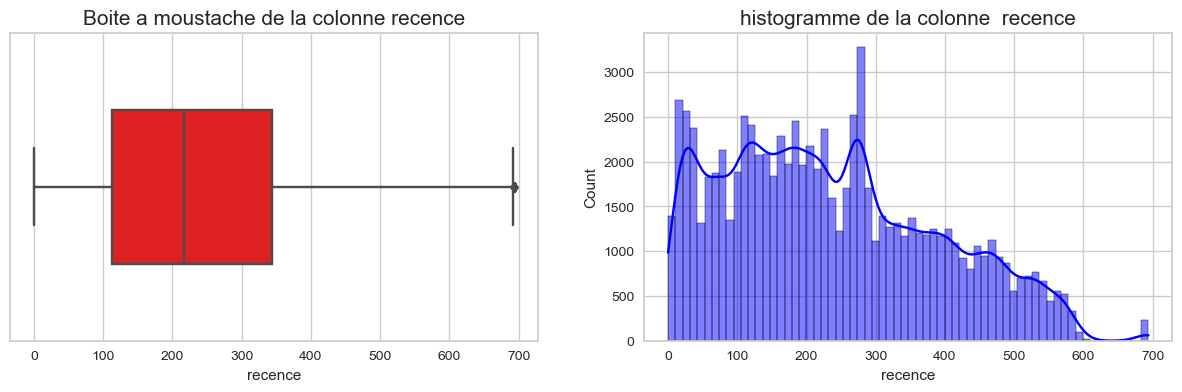

<Figure size 800x550 with 0 Axes>

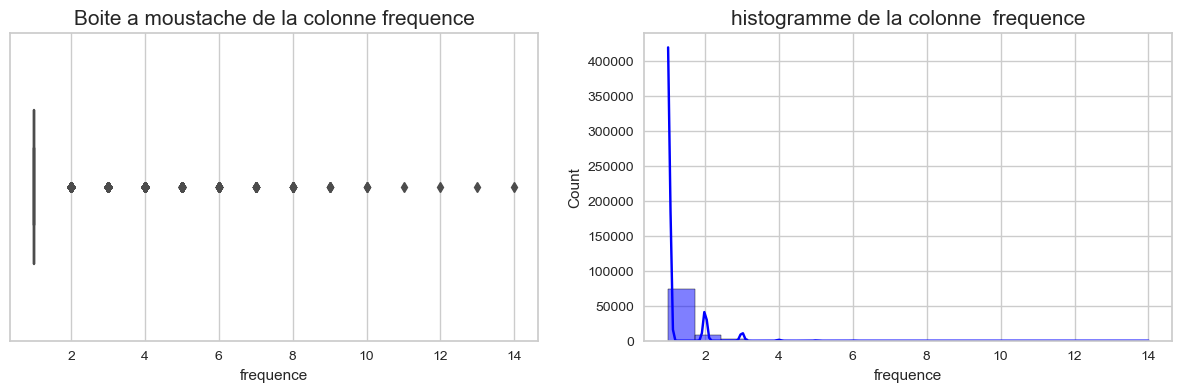

<Figure size 800x550 with 0 Axes>

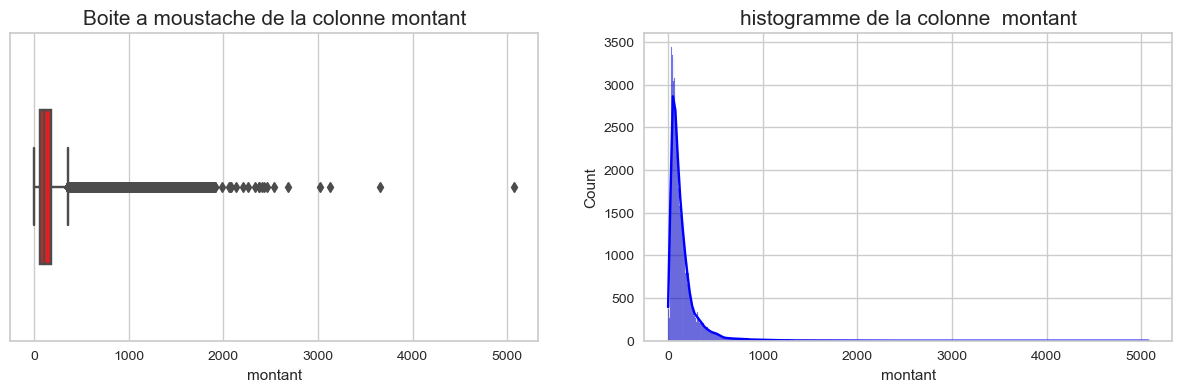

<Figure size 800x550 with 0 Axes>

In [8]:
for colonne in colonnes_rfm:
    analyse_univariee(df_rfm, colonne, str(colonne))

In [9]:
# Transformer la variable fréquence en une variable dichotomique
df_rfm['frequence'] = df_rfm['frequence'].apply(lambda x:1 if x > 1 else x)

In [10]:
df_rfm['montant'].describe()

count    84548.000000
mean       152.416570
std        171.222028
min          0.010000
25%         59.010000
50%        102.820000
75%        178.252500
max       5076.050000
Name: montant, dtype: float64

Pas de valeurs négatives, on peut donc faire une transformation logarithmique

In [11]:
# Transformation logarithmique
df_rfm_log = df_rfm.copy()
df_rfm_log['montant'] = df_rfm[['montant']].apply(np.log1p, axis=1)


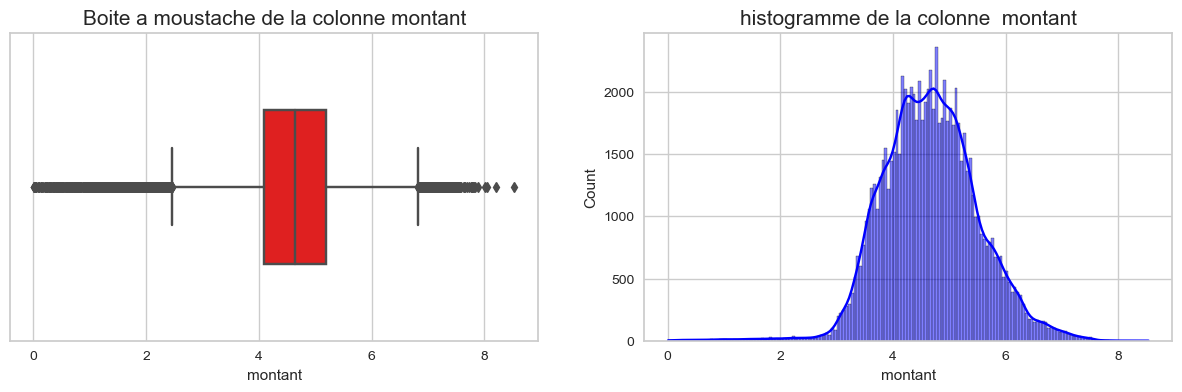

<Figure size 800x550 with 0 Axes>

In [12]:
analyse_univariee(df_rfm_log, 'montant', 'montant')


In [13]:
data_normalisee = df_rfm_log.copy()

In [14]:
# Normalisation
scaler = preprocessing.StandardScaler()
data_normalisee = scaler.fit_transform(df_rfm_log)
data_normalisee = pd.DataFrame(data_normalisee,
                               columns=['rfm_recence',
                                        'rfm_frequence',
                                        'rfm_montant'],
                               index=df_rfm.index.to_list())

# Normalisation
scaler = preprocessing.StandardScaler()
data_normalisee = scaler.fit_transform(df_rfm)
data_normalisee = pd.DataFrame(data_normalisee,
                               columns=['rfm_recence',
                                        'rfm_frequence',
                                        'rfm_montant'],
                               index=df_rfm.index.to_list())

## <span style='background:Thistle'>1.1 Score de distortion</span>

Le visualiseur K-Elbow implémente la méthode "coude" de sélection du nombre optimal de clusters pour le clustering K-means. K-means est un simple algorithme d'apprentissage automatique non supervisé qui regroupe les données en un nombre spécifié (k) de clusters. Étant donné que l'utilisateur doit spécifier à l'avance quel k choisir, l'algorithme est quelque peu naïf. Il affecte tous les membres à k clusters même si ce n'est pas le bon k pour l'ensemble de données.

La méthode du coude exécute le clustering k-means sur l'ensemble de données pour une plage de valeurs pour k (disons de 1 à 10), puis pour chaque valeur de k calcule un score moyen pour tous les clusters. Par défaut, le score de distortion est calculé, la somme des carrées des distances de chaque point à son centre assigné. D'autres métriques peuvent également être utilisées telles que le score de silhouette, le coefficient de silhouette moyen pour tous les échantillons ou le score de calinski_harabasz, qui calcule le rapport de dispersion entre et au sein des clusters.

Lorsque ces métriques globales pour chaque modèle sont tracées, il est possible de déterminer visuellement la meilleure valeur pour k. Si le graphique linéaire ressemble à un bras, alors le "coude" (le point d'inflexion sur la courbe) est la meilleure valeur de k. Le « bras » peut être vers le haut ou vers le bas, mais s'il y a un fort point d'inflexion, c'est une bonne indication que le modèle sous-jacent est le mieux adapté à ce point.

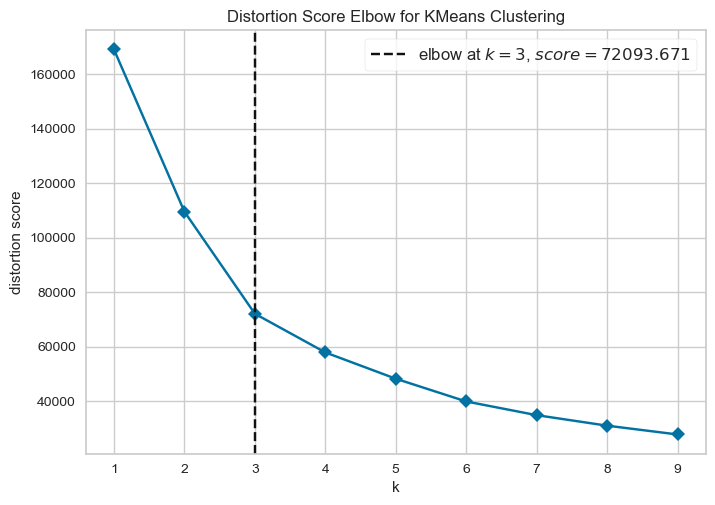

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10), timings=False)

visualizer.fit(data_normalisee)
visualizer.show()

## <span style='background:Thistle'>1.2 Score calinski_harabasz</span>

L'indice Calinski-Harabasz (CH) peut être utilisé pour évaluer le modèle lorsque les étiquettes de vérité terrain ne sont pas connues lorsque la validation de la qualité du regroupement est effectuée à l'aide de quantités et de caractéristiques inhérentes au base de données. L'indice CH (également connu sous le nom de critère de ratio de variance ) est une mesure de la similitude d'un objet avec son propre cluster (cohésion) par rapport à d'autres clusters (séparation). Ici, la cohésion est estimée sur la base des distances entre les points de données d'un cluster et son centroïde de cluster et la séparation est basée sur la distance des centroïdes de cluster par rapport au centroïde global. L'indice CH a la forme (a.Séparation)/(b.Cohésion) , où a et b sont des poids. 

Une valeur plus élevée de l'indice CH signifie que les grappes sont denses et bien séparées, bien qu'il n'y ait pas de valeur seuil « acceptable ». Nous devons choisir la solution qui donne un pic ou au moins un coude abrupt sur le tracé linéaire des indices CH. En revanche, si la ligne est lisse (horizontale ou ascendante ou descendante) alors il n'y a aucune raison de préférer une solution aux autres. 

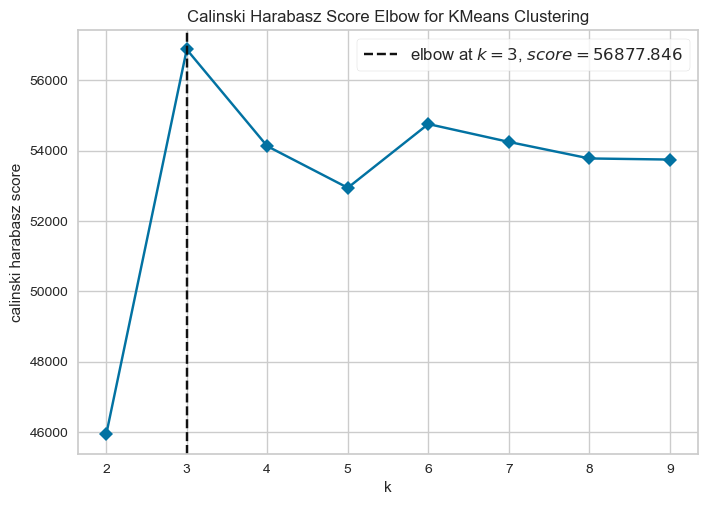

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [16]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10),
                              metric='calinski_harabasz', timings=False)
visualizer.fit(data_normalisee)
visualizer.show()

## <span style='background:Thistle'>1.3 Score silouette</span>

Le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données.

Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation).

Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien et il est donc mal classé.

A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin et il est donc bien classé.

Le coefficient de silhouette est la moyenne du coefficient de silhouette pour tous les points.

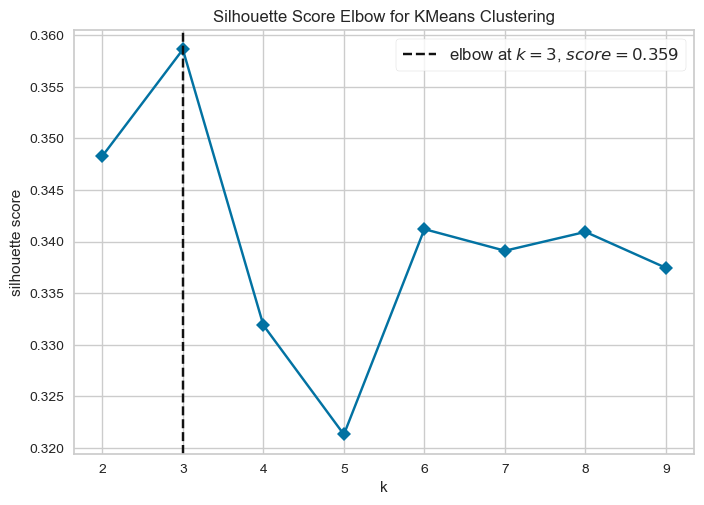

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [17]:

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10),
                              metric='silhouette', timings=False)
visualizer.fit(data_normalisee)
visualizer.show()


D'aprés les trois figures précédentes, on peut choisir 3 comme nombre de clusters

In [212]:
# Clustering avec k=4 comme meilleur hyperparamètre
cluster = KMeans(n_clusters=3, init='k-means++', max_iter=100)
cluster.fit(data_normalisee)
cluster_labels = cluster.labels_
data_rfm = data_normalisee.assign(Cluster=cluster_labels)
data_rfm.head()

rfm_recence  rfm_frequence  rfm_montant  \
0000366f3b9a7992bf8c76cfdf3221e2    -0.817427            0.0     0.354072   
0000b849f77a49e4a4ce2b2a4ca5be3f    -0.797744            0.0    -1.564567   
0000f46a3911fa3c0805444483337064     1.970951            0.0    -0.229508   
0000f6ccb0745a6a4b88665a16c9f078     0.553799            0.0    -1.021763   
0004aac84e0df4da2b147fca70cf8255     0.337290            0.0     0.738900   

                                  Cluster  
0000366f3b9a7992bf8c76cfdf3221e2        2  
0000b849f77a49e4a4ce2b2a4ca5be3f        0  
0000f46a3911fa3c0805444483337064        1  
0000f6ccb0745a6a4b88665a16c9f078        0  
0004aac84e0df4da2b147fca70cf8255        2

In [19]:
data_rfm_kmeans = pd.concat([df_rfm, data_rfm], axis=1)
data_rfm_kmeans.head()

recence  frequence  montant  rfm_recence  \
0000366f3b9a7992bf8c76cfdf3221e2      111          1   141.90    -0.817427   
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1    27.19    -0.797744   
0000f46a3911fa3c0805444483337064      536          1    86.22     1.970951   
0000f6ccb0745a6a4b88665a16c9f078      320          1    43.62     0.553799   
0004aac84e0df4da2b147fca70cf8255      287          1   196.89     0.337290   

                                  rfm_frequence  rfm_montant  Cluster  
0000366f3b9a7992bf8c76cfdf3221e2            0.0     0.354072        1  
0000b849f77a49e4a4ce2b2a4ca5be3f            0.0    -1.564567        0  
0000f46a3911fa3c0805444483337064            0.0    -0.229508        2  
0000f6ccb0745a6a4b88665a16c9f078            0.0    -1.021763        0  
0004aac84e0df4da2b147fca70cf8255            0.0     0.738900        1

In [20]:
data_rfm_kmeans['Cluster'].value_counts(normalize=True) * 100

0    37.051143
1    33.068789
2    29.880068
Name: Cluster, dtype: float64

In [21]:
def taille_cluster(labels):
    global cluster_size
    cluster_size = {}
    for i in labels:
        if i not in cluster_size:
            cluster_size[i] = 1
        else:
            cluster_size[i] += 1

    fig = plt.figure(figsize=[8, 8])
    fig.patch.set_alpha(0.7)
    plt.title("Clusters size ")
    plt.bar(range(0, len(cluster_size)), cluster_size.values())
    for i, num in enumerate(cluster_size.keys()):
        height = cluster_size[num]+20
        x = i - 0.25
        pourcent = cluster_size[num]/labels.shape[0]*100
        plt.text(x, height, "{} % ".format(round(pourcent, 2)))
    plt.xticks(range(0, len(cluster_size)), cluster_size.keys())

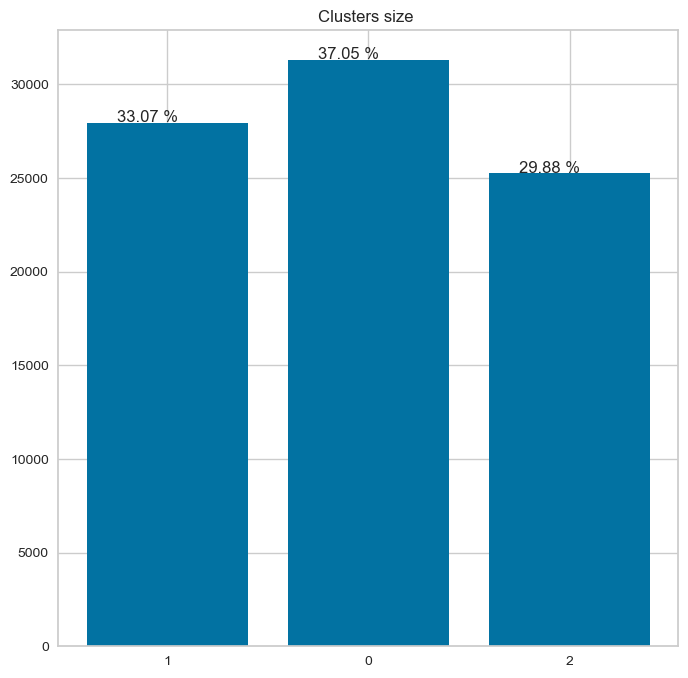

In [22]:
taille_cluster(cluster_labels)

In [23]:
groupe = data_rfm_kmeans.groupby(['Cluster'])
groupe.agg({
    'recence': ['min', 'mean', 'median', 'max'],
    'frequence': ['min', 'mean', 'median', 'max'],
    'montant': ['min', 'mean', 'median', 'max']}).round(1)

recence                    frequence                 montant         \
            min   mean median  max       min mean median max     min   mean   
Cluster                                                                       
0             0  150.8  150.0  546         1  1.0    1.0   1     0.0   61.5   
1             0  161.1  158.0  560         1  1.0    1.0   1   110.4  278.8   
2           260  423.2  415.0  694         1  1.0    1.0   1     0.7  125.3   

                        
        median     max  
Cluster                 
0         59.8   116.6  
1        200.3  5076.0  
2         98.2  2074.3

In [24]:
def distribution_cluster(df, colonnes):
    for k in colonnes:
        sns.boxplot(data=df[[k, "Cluster"]], x="Cluster", y=k)
        plt.xticks()
        plt.title("Distribution de " + k + " dans les clusters")
        plt.show()

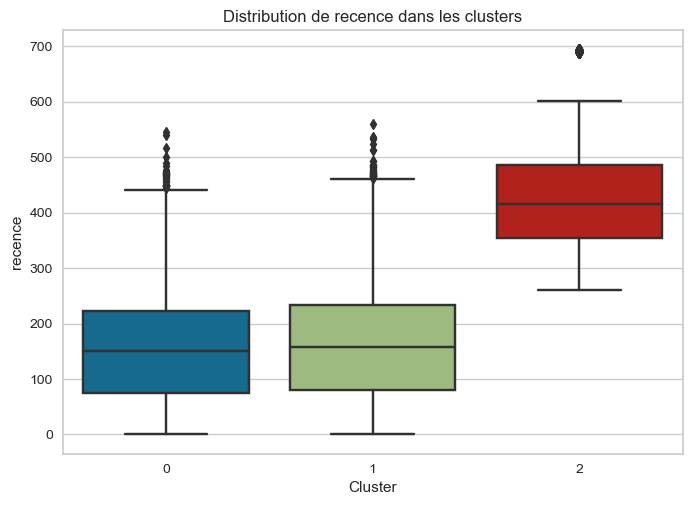

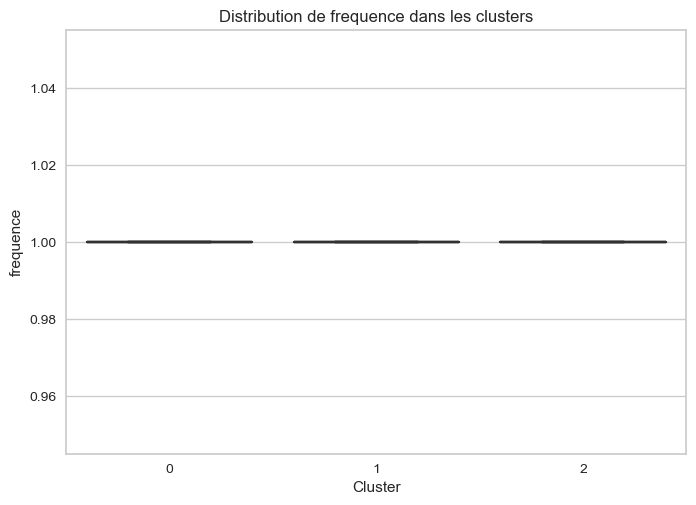

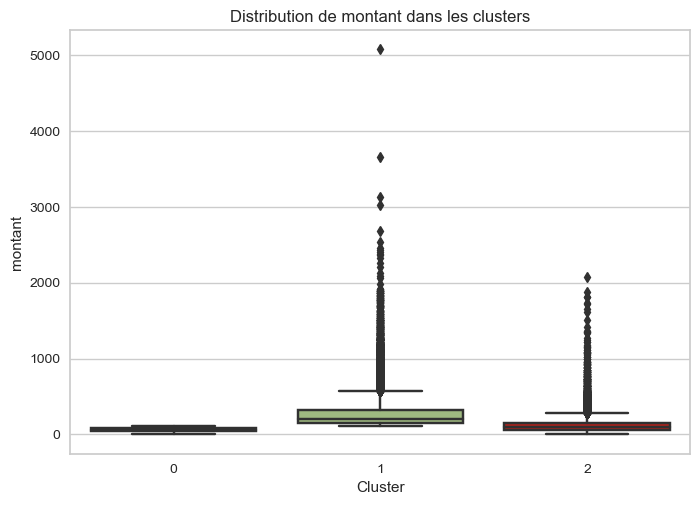

In [25]:
colonnes_rfm = ["recence", "frequence", "montant"]
distribution_cluster(data_rfm_kmeans, colonnes_rfm)

## <span style='background:Thistle'>1.3 Conclusion</span>

50 % - groupe 0 (Les Clients Nouveaux) avec la plus petite récence, la plus petite frequence et la plus petite valeur monétaire : 
Ce sont des clients qui n'achetent pas beaucoup, mais qui peuvent encore acheter à nouveau.

37 % - groupe 3 (Les Clients Perdus) avec la plus grande récence, fréquence la plus petite et la plus petite valeur monétaire : Clients non fidèles.
Ce sont des clients qui ont acheté depuis longtemps, n'achètent pas souvent et ne  dépensent pas beaucoup.

10 % - groupe 1 (Les Clients à risque) avec récence intermédiare, fréquence intermédiare et une valeur monétaire importante : 
Ce sont des clients qui ont acheté il y a longtemps, seulement quelques fois et qui ont dépensé beaucoup


2% - groupe 2 (Les Clients fidèles) avec grande récence, la plus grande fréquence et la plus grande valeur monétaire : Client fidèles
Ce sont des clients qui n'ont pas acheté récemment, avec une grande fréquence et qui dépensent beaucoup. Clients nécessitant une grande attention.

## <span style='background:Thistle'>1.4 Visualisation TSNE</span>


In [26]:
def visualisation_tsne(df, cluster_labels):
    # Plot t-SNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)

    plt.figure(figsize=(15, 5))

    plt.title('Visualisation des clusters en utilisant TSNE')
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    hue=cluster_labels, palette='Set1')
    plt.show()

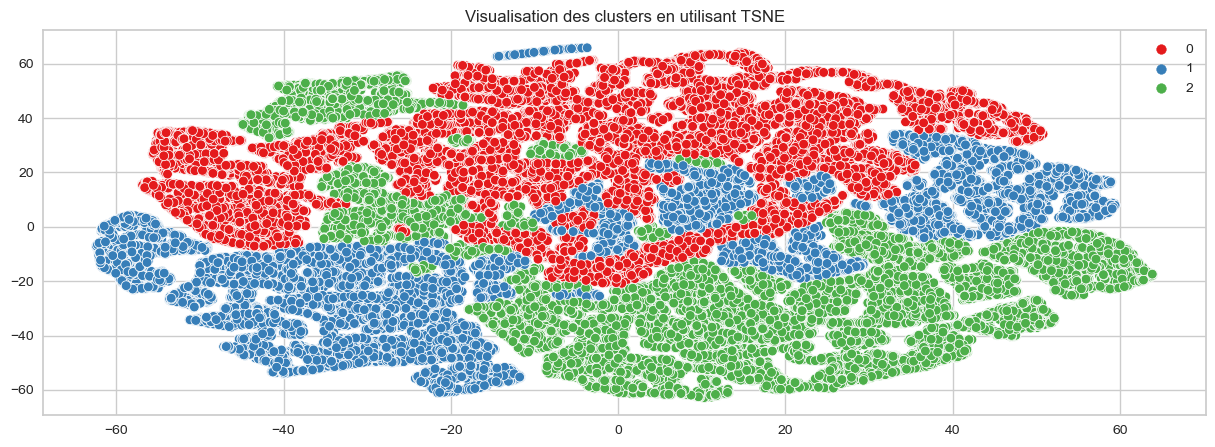

In [213]:
visualisation_tsne(data_rfm, cluster_labels)

##  <span style='background:Thistle'>2. Apprentissage non supervisé</span>

In [28]:

# Ajouter les colonnes RFM au dataframe
data = pd.merge(data, dataa_rfm, on='customer_unique_id')
data = data.drop(['nbre_produit','montant_achat'],1)
dataaaa = data.copy()
#data.to_csv('data.maint.csv', index=False)


In [29]:
# Sélectionner un échantillon de 30000 lignes
data = data.sample(n=30000, random_state=2)

In [30]:
def comparaison_distribution(df1, df2, colonne_cible):
    colonne_cible_apres_echantillonnage = colonne_cible+'_apres_echantillonnage'
    sns.kdeplot(colonne_cible, data=df1, label=colonne_cible)
    sns.kdeplot(colonne_cible, data=df2, label=colonne_cible_apres_echantillonnage)
    plt.title(f'comparaison des distribution {colonne_cible}')
    plt.legend()
    plt.show()

In [31]:
colonnes_a_normaliser = data.select_dtypes(include=[np.number])\
                        .columns.tolist()

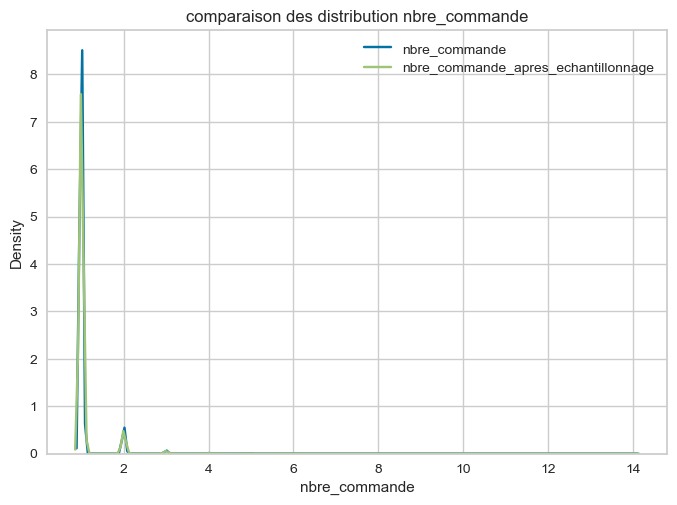

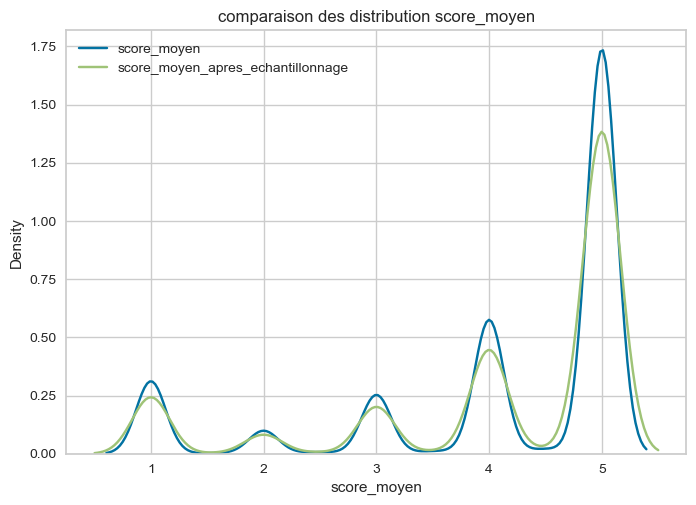

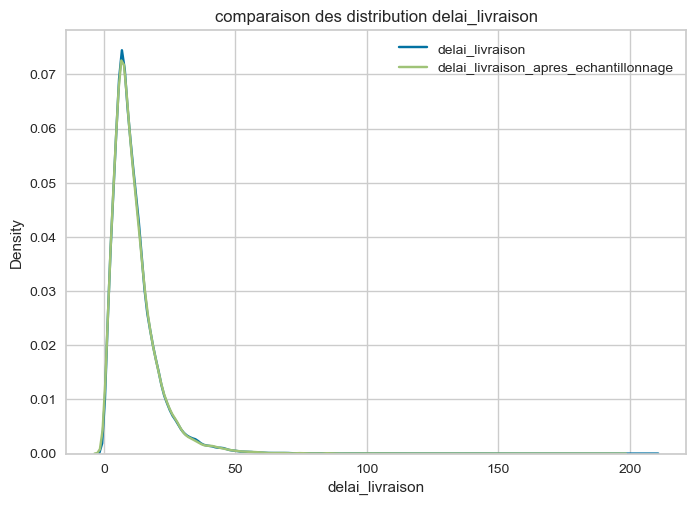

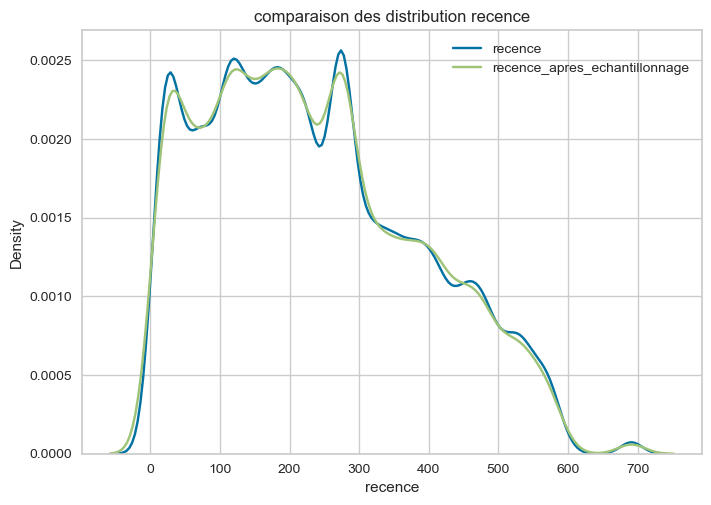

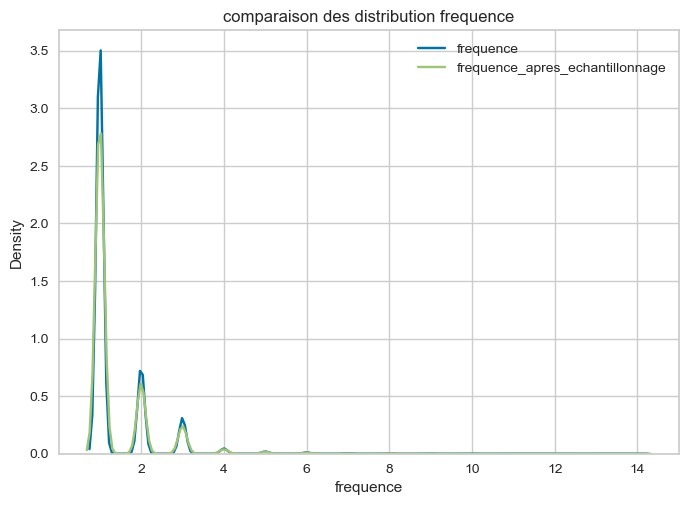

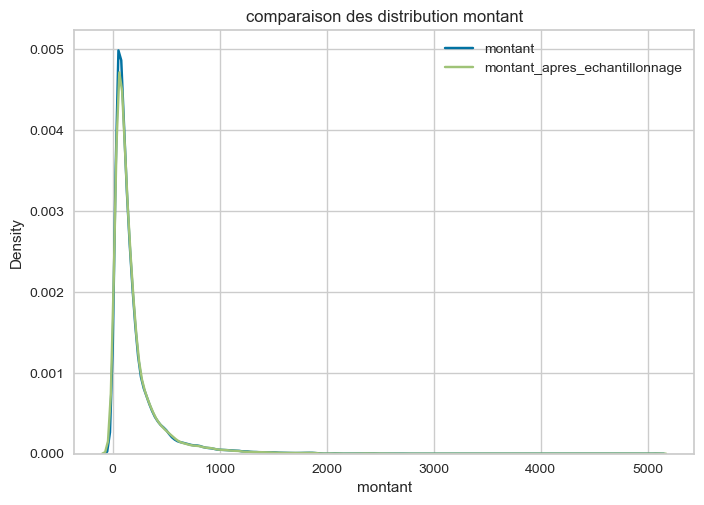

In [32]:
for colonne_cible in colonnes_a_normaliser:
    comparaison_distribution(dataaaa, data, colonne_cible)

Nous remarquons que les variables ont la meme forme de distribution avant et après échantillonnage.
Nous pouvons considérer donc que l'échantillon est représentatif du jeu de données

In [33]:
###  <span style='background:Thistle'>2. Analyse univariée</span>

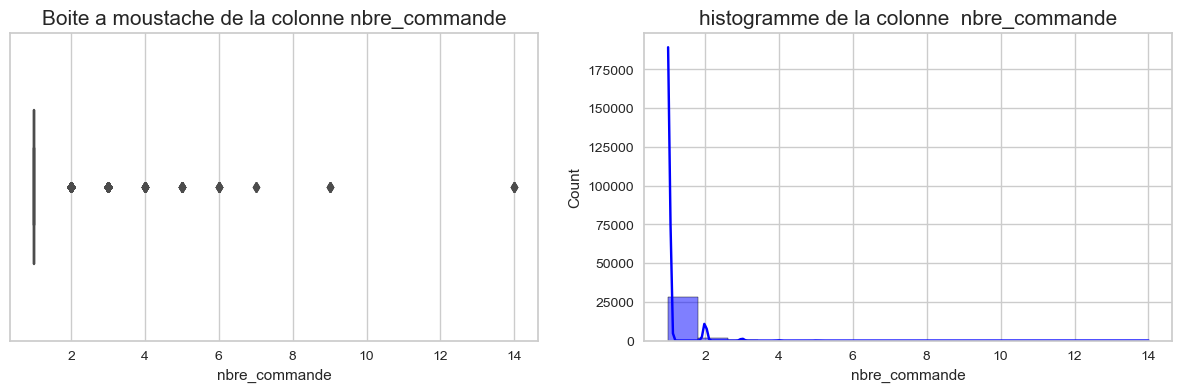

<Figure size 800x550 with 0 Axes>

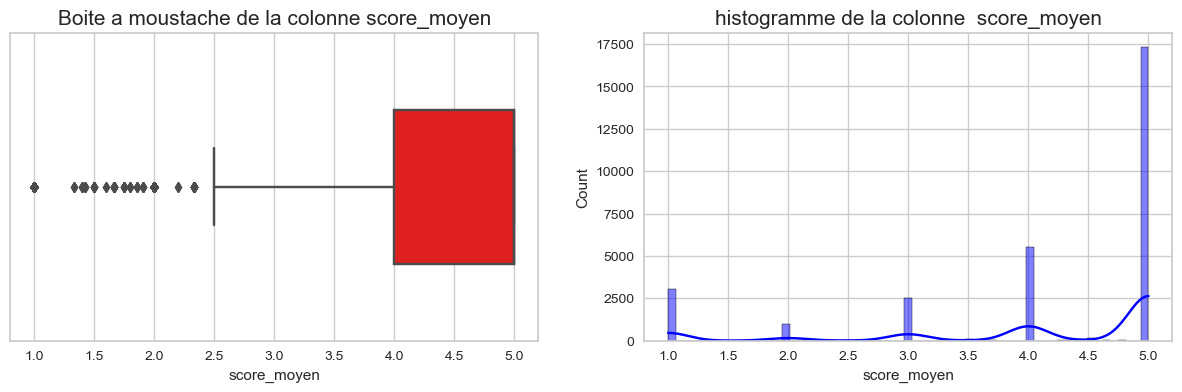

<Figure size 800x550 with 0 Axes>

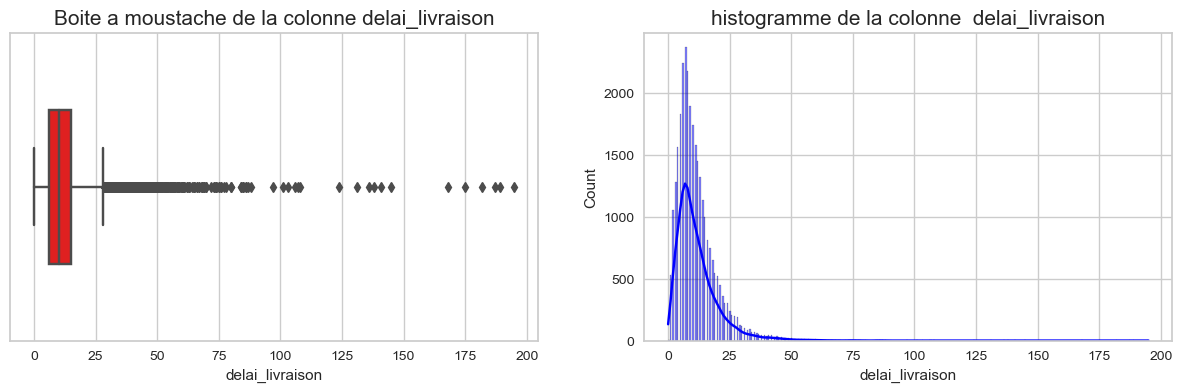

<Figure size 800x550 with 0 Axes>

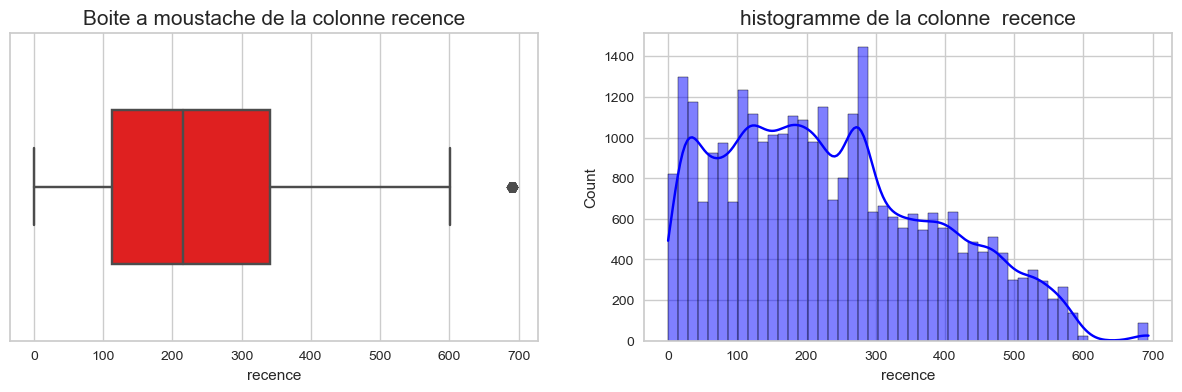

<Figure size 800x550 with 0 Axes>

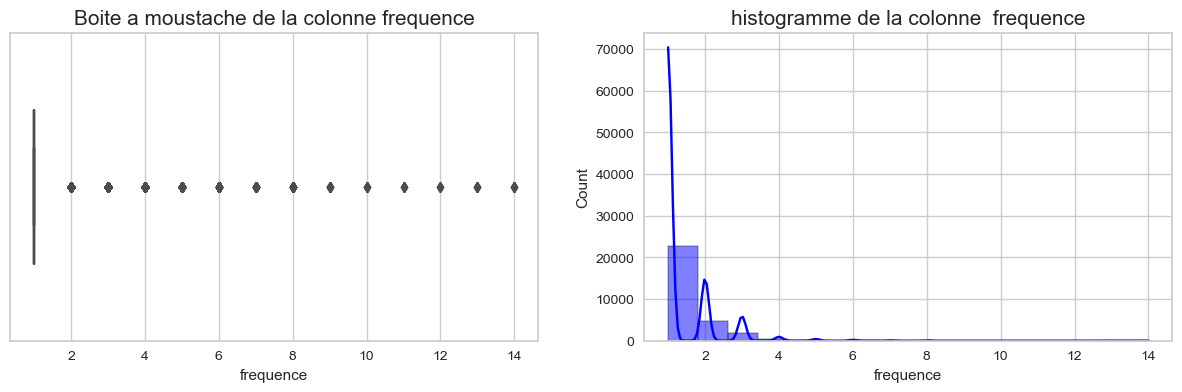

<Figure size 800x550 with 0 Axes>

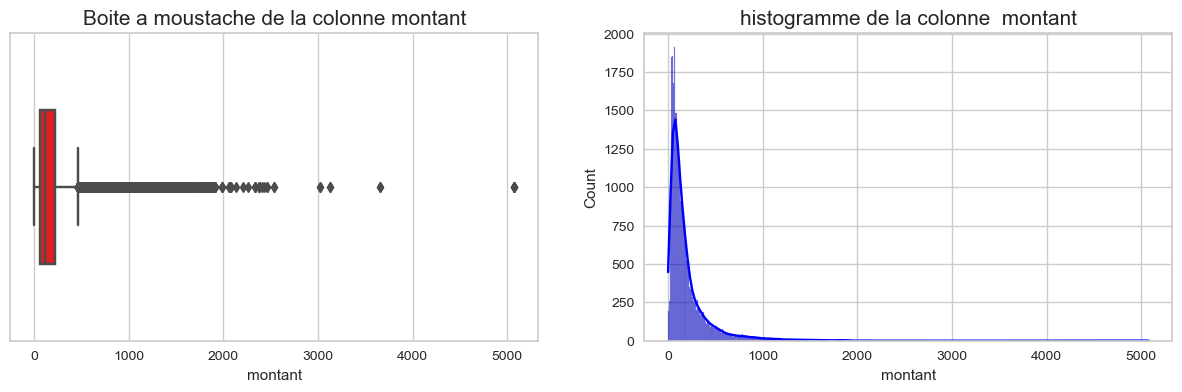

<Figure size 800x550 with 0 Axes>

In [34]:
for colonne in colonnes_a_normaliser:
    analyse_univariee(data, colonne, str(colonne))

In [35]:
# Transformation logarithmique 
data_log = data[colonnes_a_normaliser].apply(np.log1p, axis=1)


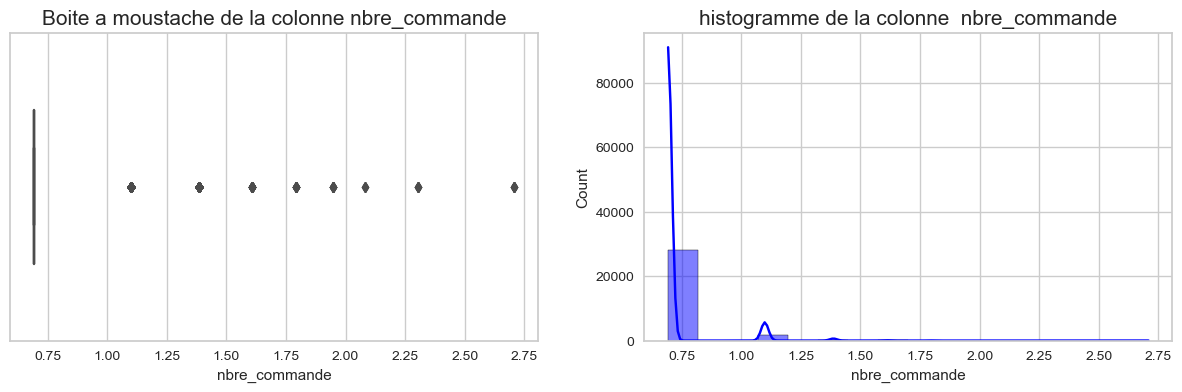

<Figure size 800x550 with 0 Axes>

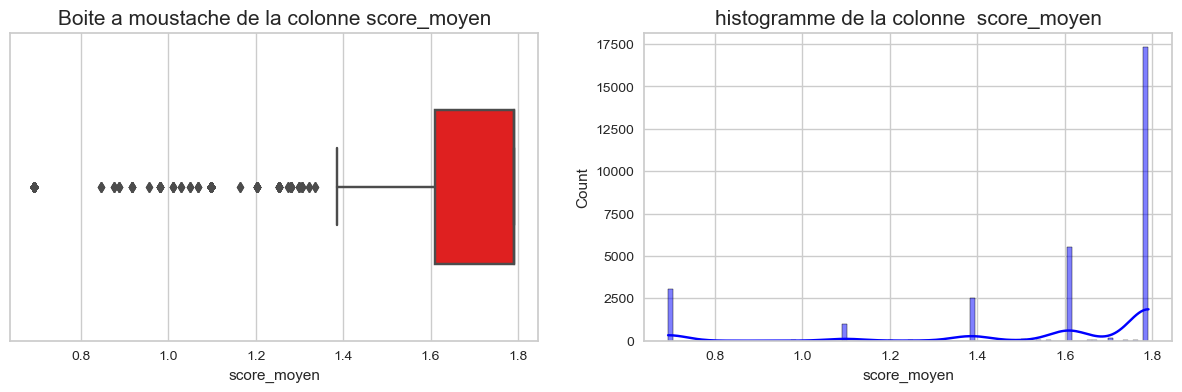

<Figure size 800x550 with 0 Axes>

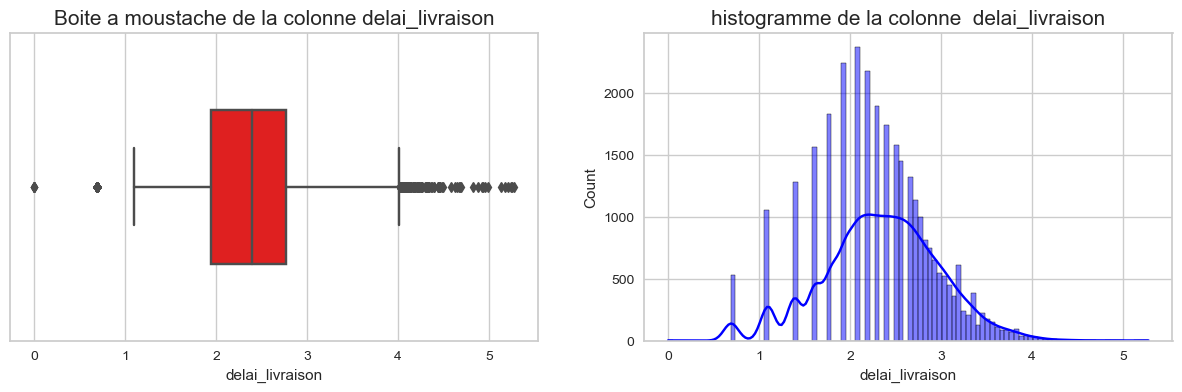

<Figure size 800x550 with 0 Axes>

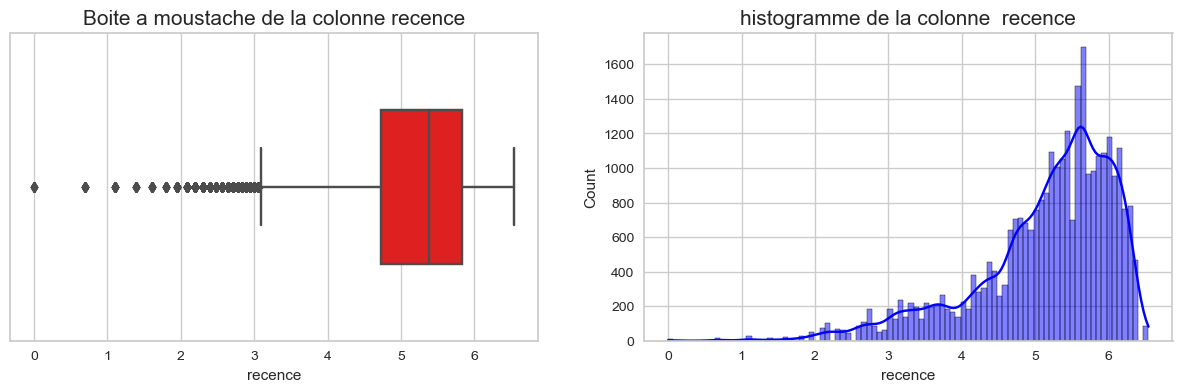

<Figure size 800x550 with 0 Axes>

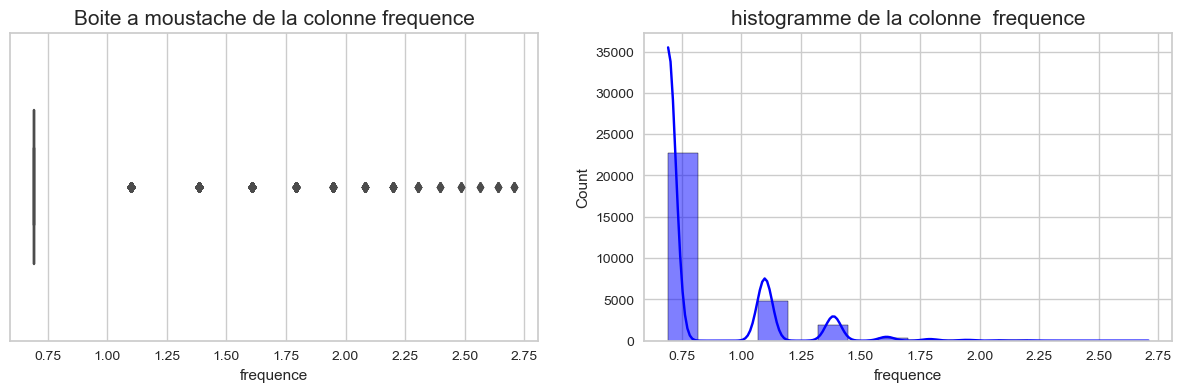

<Figure size 800x550 with 0 Axes>

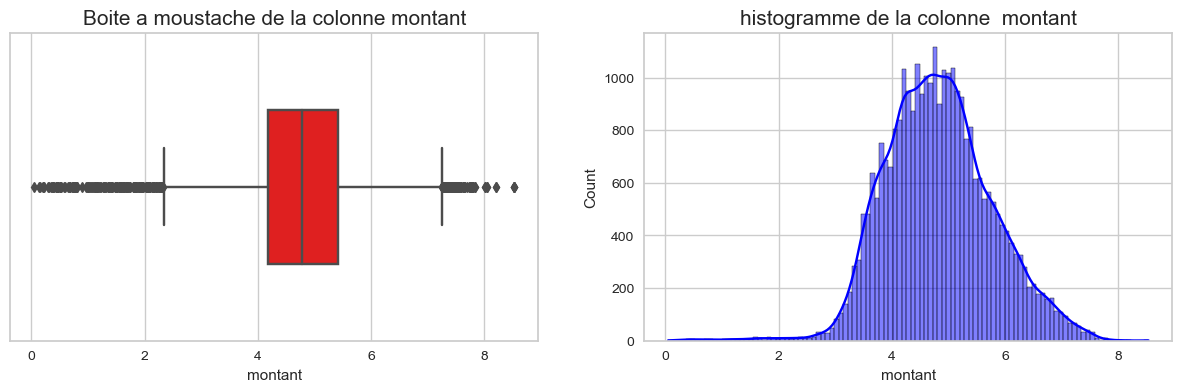

<Figure size 800x550 with 0 Axes>

In [36]:
for colonne in colonnes_a_normaliser:
    analyse_univariee(data_log, colonne, str(colonne))

In [37]:
data_a_normaliser = data_log[colonnes_a_normaliser].copy()
scaler = preprocessing.StandardScaler()
''''
data_a_normaliser = scaler.fit_transform(data_a_normaliser)
data_a_normaliser = pd.DataFrame(data_a_normaliser,
                                 columns=colonnes_a_normaliser,
                                 index=data.index.to_list())
'''
for colonne in colonnes_a_normaliser:
    data[colonne] = data_a_normaliser[colonne]


 ## <span style='background:Thistle'>2.2 Encodage</span>

Le one hot encoding est la méthode la plus populaire pour transformer une variable catégorique en variable numérique. Sa popularité réside principalement dans la facilité d’application. De plus, pour beaucoup de problèmes, elle donne de bons résultats. Son principe est le suivant :

Considérons une variable catégorique X qui admet K modalités m1, m2, …, mK. Le one hot encoding consiste à créer K variables indicatrices, soit un vecteur de taille K qui a des 0 partout et un 1 à la position i correspondant à la modalité mi. On remplace donc la variable catégorique par K variables numériques.

In [38]:
colonnes_categoriques = ['customer_state', 'payment_type',
                         'product_category_name']

In [39]:
def encodage_categorielle(data, colonne):
    df_encodage = pd.get_dummies(data[colonne], prefix=colonne)
    return (df_encodage)

In [40]:
data_encodage_categorielle = pd.DataFrame(index=data.index)
for colonne in colonnes_categoriques:
    df_encodage = encodage_categorielle(data, colonne)
    data_encodage_categorielle = pd.concat([data_encodage_categorielle,
                                            df_encodage], axis=1)

In [41]:
data = data.drop(colonnes_categoriques, 1)

In [42]:
data = pd.concat([data, data_encodage_categorielle], axis=1)

In [43]:
data = data.drop('order_purchase_timestamp', 1)
data1 = data.copy()
data = data.set_index('customer_unique_id')

## <span style='background:Thistle'>2.4 Algorithmes de clustering</span>


### <span style='background:Thistle'>2.4.1 Kmeans</span>


K-Means est un algorithme simple d’apprentissage non supervisé utilisé pour résoudre les problèmes de clustering. Il suit une procédure simple consistant à classer un ensemble de données dans un nombre de clusters, défini par la lettre « k« , qui est fixé au préalable.

On positionne ensuite les clusters comme des points. On associe tous les observations ou points de données au cluster le plus proche, calculés et ajustés. Puis, le processus recommence en utilisant les nouveaux ajustements jusqu’à ce qu’un résultat souhaité soit atteint.

In [44]:
X = data.copy()

#### <span style='background:Thistle'>2.4.1.1 Score de distortion</span>

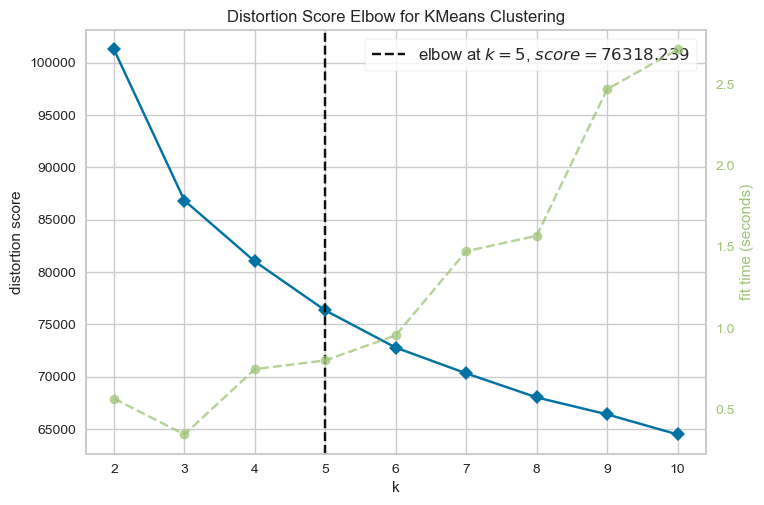

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11), timings=True)
visualizer.fit(X)
visualizer.show()

#### <span style='background:Thistle'>2.4.1.2 Score calinski_harabasz</span>

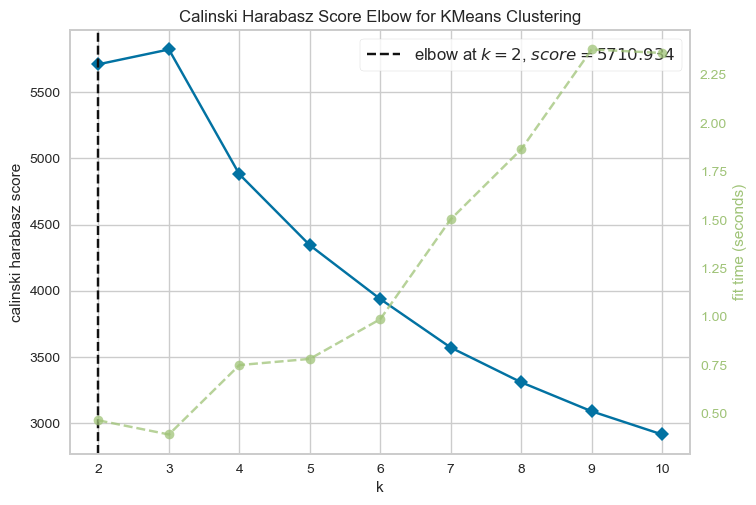

In [46]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11),
                              metric='calinski_harabasz',
                              timings=True)
visualizer.fit(X)
visualizer.poof()
plt.show()

#### <span style='background:Thistle'>2.4.1.3 Silouette</span>

In [47]:
n_clusters = range(2, 11)
scores = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    labs = kmeans.labels_
    score = silhouette_score(X, labs)
    scores.append(score)

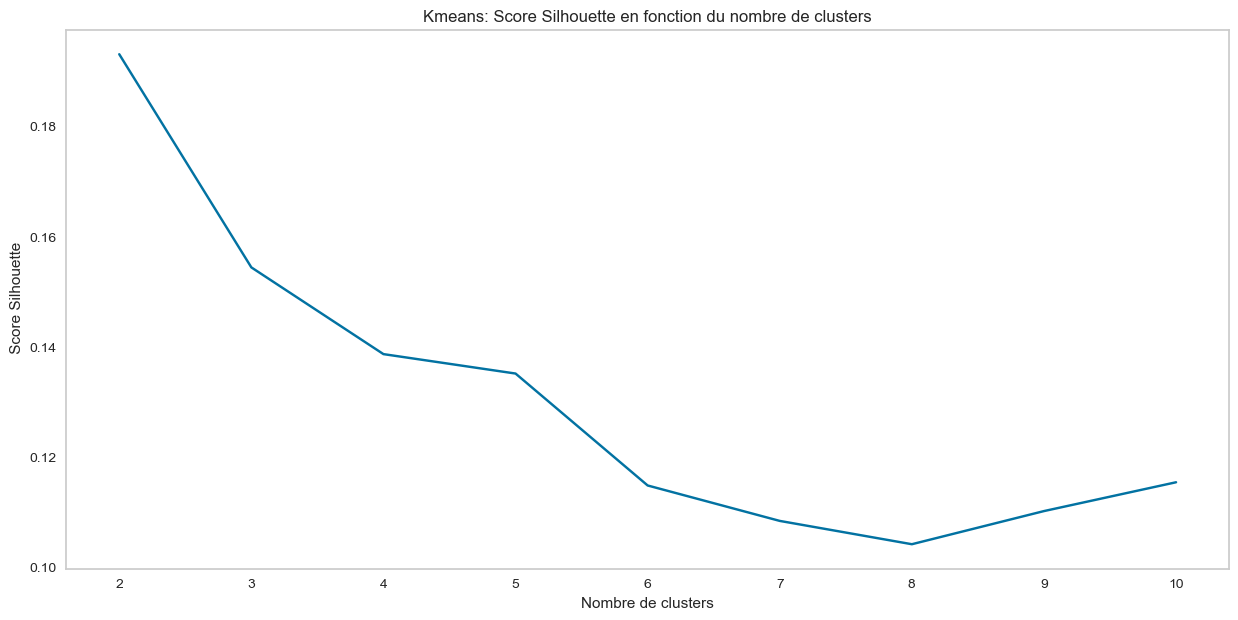

In [48]:
fig = plt.figure(figsize=[15, 7])
fig.patch.set_alpha(0.7)
plt.title("Kmeans: Score Silhouette en fonction du nombre de clusters")
plt.plot(n_clusters, scores)
plt.ylabel(" Score Silhouette")
plt.xlabel("Nombre de clusters")
plt.grid()

D'aprés les trois figures précédentes, on peut choisir 6 comme nombre de clusters

In [49]:
# Clustering avec k=5 comme meilleur hyperparamètre
cluster = KMeans(n_clusters=5, init='k-means++', max_iter=100)
preds = cluster.fit_predict(X)
#preds = cluster.fit(X)
cluster_labels = cluster.labels_
data_kmeans = X.assign(Cluster=cluster_labels)
silh = silhouette_score(X, preds)
db = davies_bouldin_score(X, preds)
cal_har = calinski_harabasz_score(X, preds)
metrique_kmeans_opt = {
        'coef_silh': silh,
        'davies_bouldin': db,
        'calinski_harabasz': cal_har}
metrique_kmeans_opt

{'coef_silh': 0.13438129926157116,
 'davies_bouldin': 1.9845706063267783,
 'calinski_harabasz': 4343.944100095719}

Le visualiseur de silhouette affiche le coefficient de silhouette pour chaque cluster, en évaluant visuellement leur densité et leur séparation par rapport aux autres clusters.

Le score est calculé en faisant la moyenne du coefficient de silhouette pour chaque échantillon par cluster, calculé comme la différence entre la distance moyenne intra-cluster et la distance moyenne au plus proche cluster pour chaque échantillon, normalisée par la valeur maximale.
Cela donne un score entre -1 et +1, où les scores proches de +1 indiquent une séparation élevée et les scores proches de -1 indiquent que les échantillons peuvent avoir été affectés au mauvais cluster.

Dans les graphiques de SilhouetteVisualizer, les clusters ayant des scores plus élevés ont des silhouettes plus larges, mais les grappes qui sont moins cohésives n'atteignent pas le score moyen de toutes les cluster, qui est représenté par une ligne verticale pointillée en rouge.

# Instantiate the clustering model and visualizer
visualizer = SilhouetteVisualizer(cluster)
visualizer.fit(X)
visualizer.poof()

In [50]:
data_kmeans['Cluster'].value_counts(normalize=True) * 100

0    26.846667
2    21.570000
1    20.896667
3    15.793333
4    14.893333
Name: Cluster, dtype: float64

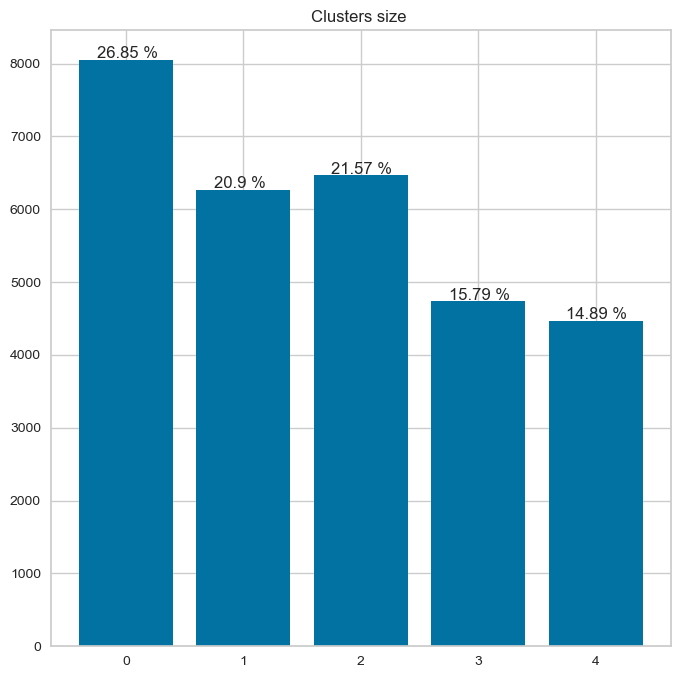

In [51]:
taille_cluster(cluster_labels)

#### <span style='background:Thistle'>2.4.1.4 Visualisation avec TSNE</span>

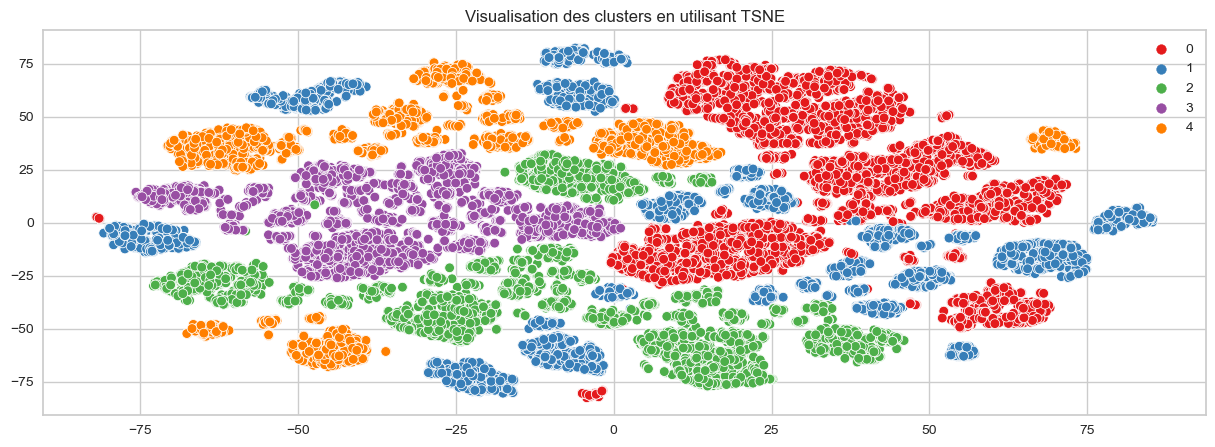

In [137]:
data_kmeans_tsne = data_kmeans.copy()
visualisation_tsne(data_kmeans_tsne, cluster_labels)

#### <span style='background:Thistle'>2.4.1.5 Analyse des clusters</span>

In [53]:
def valeur_present(variable, df, cluster):
    val_pres = {}
    df_loc = df.loc[df["Cluster"] == cluster]
    categ_pres = list(df_loc[variable].values)
    liste_categ = {}
    for mot in categ_pres:
        if mot in liste_categ:
            liste_categ[mot] += 1
        else:
            liste_categ[mot] = 1

    val_plus_pres = sorted(liste_categ, key=liste_categ.get, reverse=True)
    categ_3 = val_plus_pres[:3]
    taille = df_loc.shape[0]
    for i in categ_3:
        dff_loc = df_loc.loc[df_loc[variable] == i]
        n = dff_loc.shape[0]/taille*100
        val_pres[i] = round(n, 1)
    return val_pres

In [54]:
def cluster_analysis(n_cluster, df):
    region_pres = valeur_present("customer_state", df, n_cluster)
    categ_pres = valeur_present("product_category_name", df, n_cluster)
    payment_pres = valeur_present("payment_type", df, n_cluster)

    fig = plt.figure(1, figsize=[19, 5])
    fig.patch.set_alpha(0.7)
    plt.suptitle("Cluster {}: {} clients".format(n_cluster,
                 cluster_size[n_cluster]), fontweight="bold", size=20)
    plt.subplot(1, 3, 1)
    plt.title("Les 3 régions les plus présentes", fontweight="bold", size=15)
    plt.bar(range(0, len(region_pres)), region_pres.values())
    plt.xticks(range(0, len(region_pres)), region_pres.keys(),
               rotation=90, fontweight="bold", size=15)
    plt.ylabel("Percentage")

    plt.subplot(1, 3, 2)
    plt.title("Les 3 catégories les plus présentes",
              fontweight="bold", size=15)
    plt.bar(range(0, len(categ_pres)), categ_pres.values())
    plt.xticks(range(0, len(categ_pres)), categ_pres.keys(),
               rotation=90, fontweight="bold", size=15)

    plt.subplot(1, 3, 3)
    plt.title("Les 3 moyens de paiements les plus présents",
              fontweight="bold", size=15)
    plt.bar(range(0, len(payment_pres)),
            payment_pres.values())
    plt.xticks(range(0, len(payment_pres)),
               payment_pres.keys(),
               rotation=90, fontweight="bold", size=15)
    plt.show()

In [55]:
data_kmeans_analyse = data_olist.sample(n=30000, random_state=2).copy()
data_kmeans_analyse = data_kmeans_analyse.set_index('customer_unique_id')
data_kmeans_analyse["Cluster"] = data_kmeans["Cluster"]

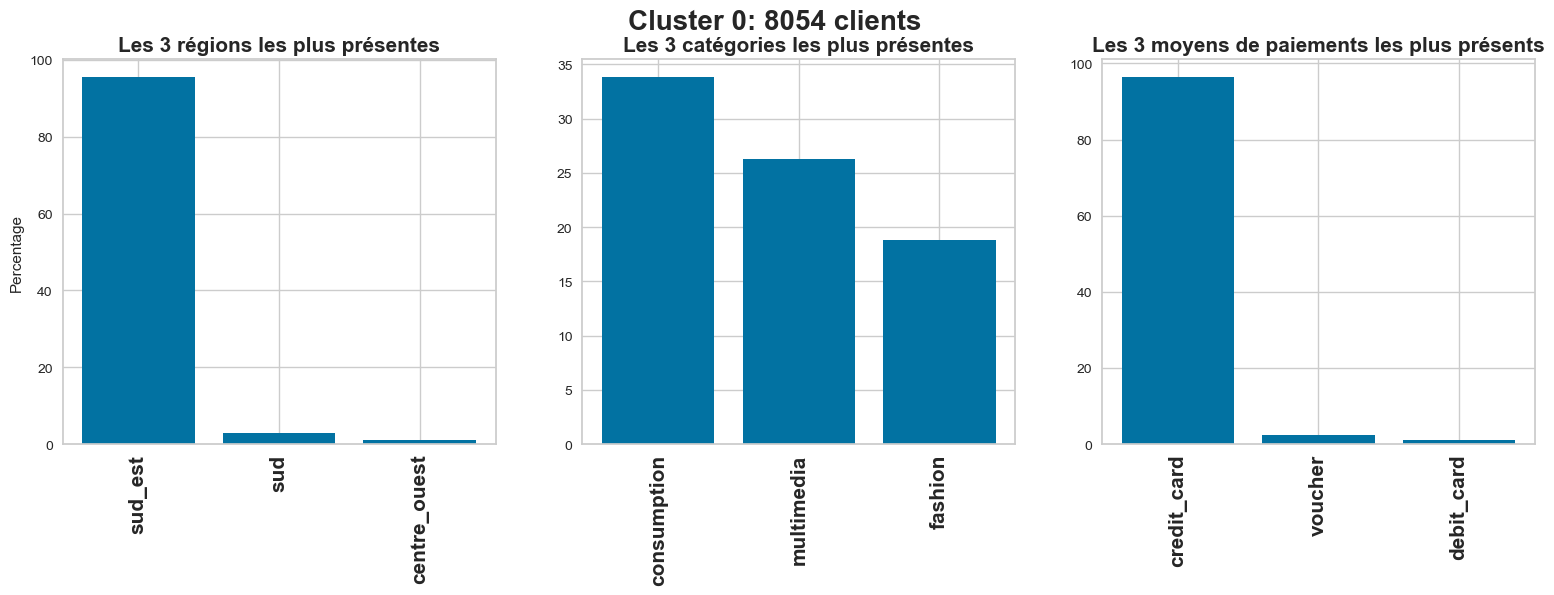

In [56]:
cluster_analysis(0, data_kmeans_analyse)

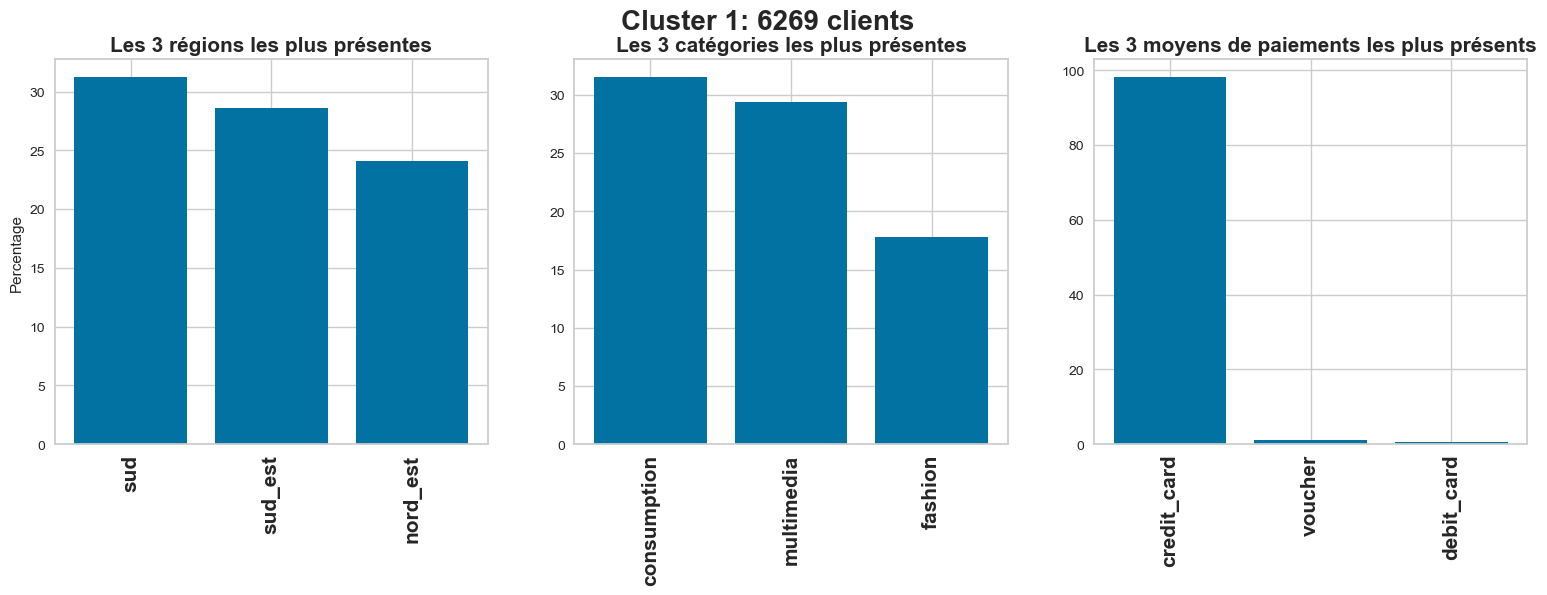

In [57]:
cluster_analysis(1, data_kmeans_analyse)

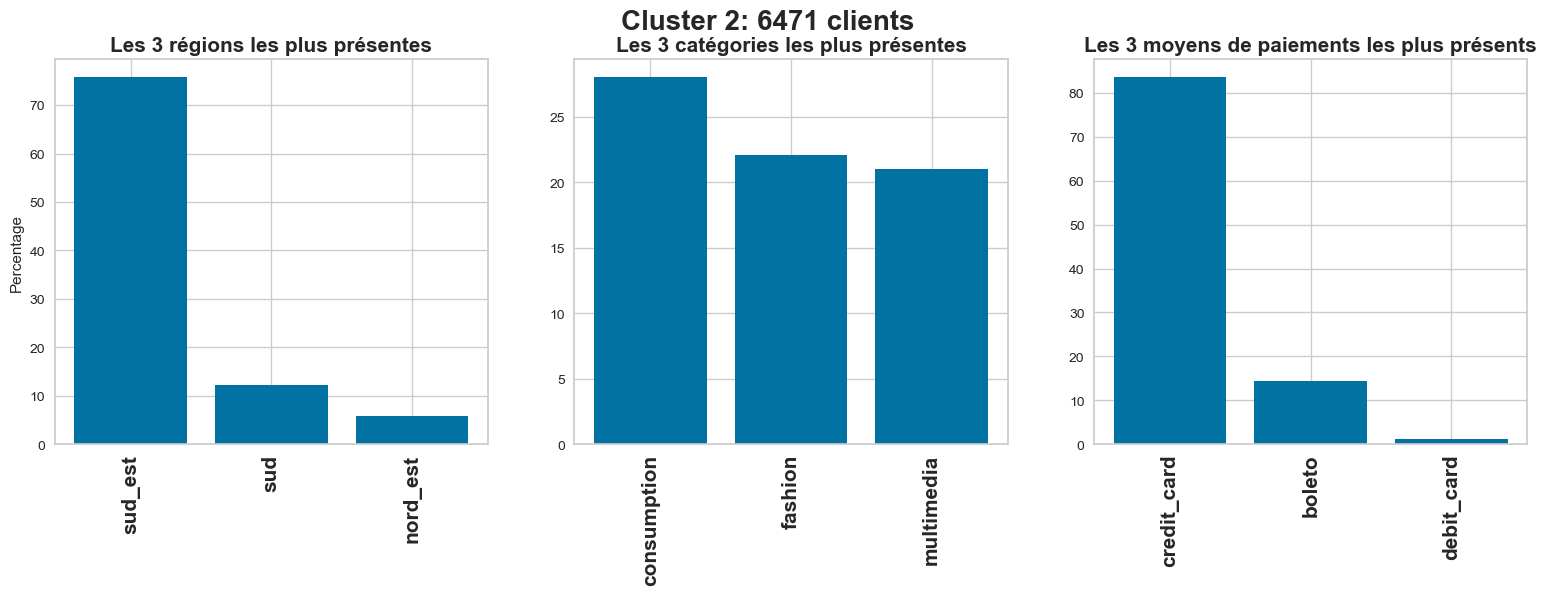

In [58]:
cluster_analysis(2, data_kmeans_analyse)

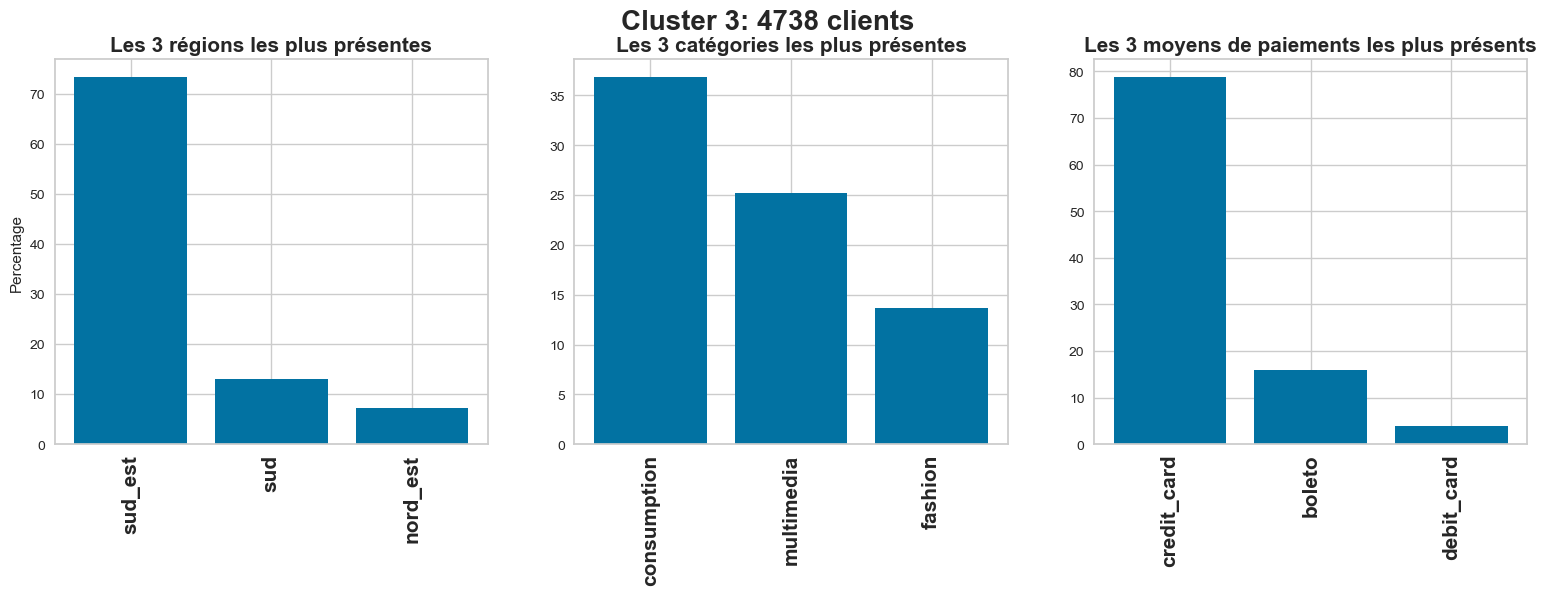

In [59]:
cluster_analysis(3, data_kmeans_analyse)

In [60]:
cluster_analysis(4, data_kmeans_analyse)

In [61]:
groupe_kmeans = data_kmeans_analyse.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
groupe_kmeans.agg({
                  'recence': ['min', 'mean', 'median', 'max'],
                  'frequence':  ['min', 'mean', 'median', 'max'],
                  'montant':  ['min', 'mean', 'median', 'max'],
                  'score_moyen':  ['min', 'mean', 'median', 'max'],
                  'delai_livraison':  ['min', 'mean', 'median', 'max']
                  }).round(1)

recence                    frequence                 montant         \
            min   mean median  max       min mean median max     min   mean   
Cluster                                                                       
0            30  279.3  266.0  694         1  1.1    1.0   5     0.0   77.0   
1            39  269.8  246.0  694         1  1.1    1.0   4     4.5  128.4   
2            20  256.6  232.0  694         1  2.2    2.0  13   150.1  507.0   
3             0   36.1   32.0  109         1  1.3    1.0  14     0.7  163.1   
4            46  280.2  267.0  694         1  1.1    1.0   6     6.9  108.0   

                       score_moyen                  delai_livraison        \
        median     max         min mean median  max             min  mean   
Cluster                                                                     
0         68.1   244.2         1.0  4.4    5.0  5.0               0   7.7   
1        117.8   771.6         1.0  3.8    4.0  5.0               3  19.8   
2        391.1  5076.0         1.0  3.9    5.0  5.0               0  11.1   
3        118.0  1917.6         1.0  4.3    5.0  5.0               0   7.3   
4         87.7   383.0         1.0  4.2    5.0  5.0               1  13.3   

                     
        median  max  
Cluster              
0          7.0   50  
1         17.0  195  
2         10.0  124  
3          6.0   88  
4         12.0  189

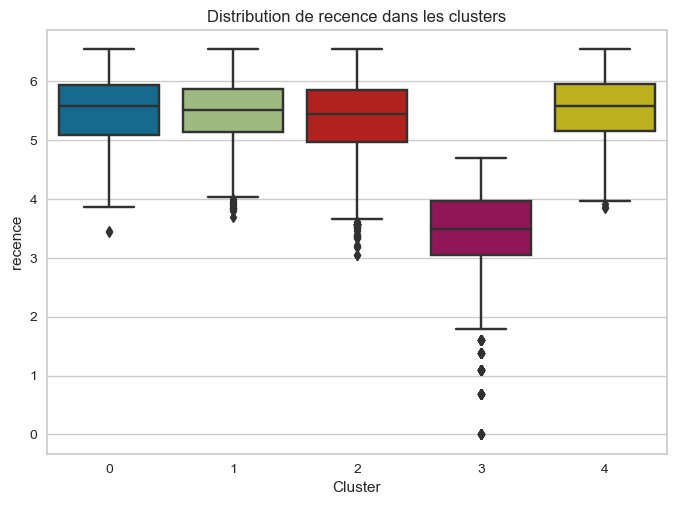

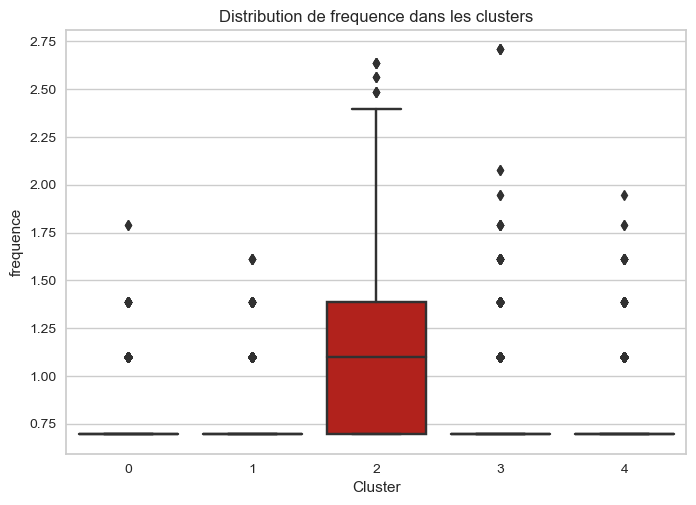

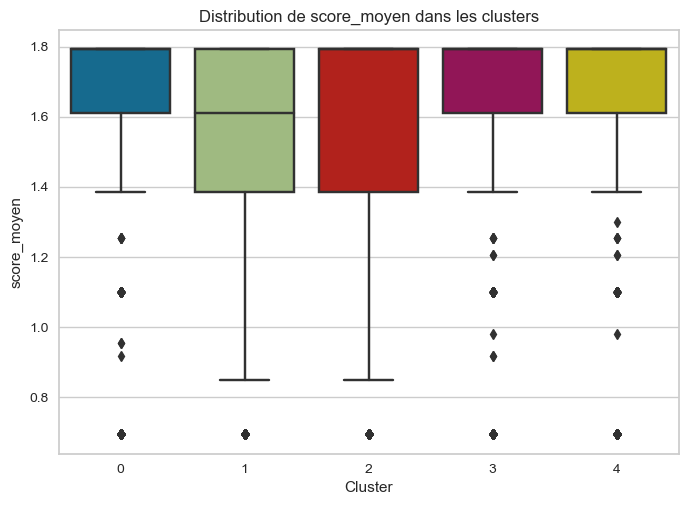

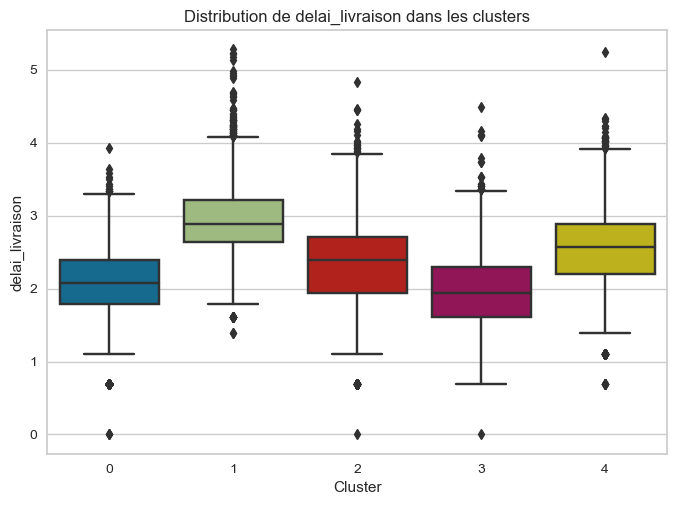

In [62]:
colonnes_kmeans = ["recence", "frequence", "montant",
                   "score_moyen", "delai_livraison"]
distribution_cluster(data_kmeans, colonnes_kmeans)


### <span style='background:Thistle'>2.4.2 Agglomerative clustering</span>


Dans le cas du clustering agglomératif (ou bottom-up), on commence par considérer que chaque point est un cluster à lui tout seul. Ensuite, on trouve les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points appartiennent à un seul cluster, constitué de l'agglomération de tous les clusters initiaux.

L'approche inverse, le clustering divisif (ou top-down), consiste à initialiser avec un unique cluster contenant tous  les points, puis à itérativement séparer chaque cluster en plusieurs, jusqu'à ce que chaque point appartienne à son propre cluster.

Le clustering agglomératif est trop gourmand en mémoire. Je vais travailler sur échantillon de 30000 observations

In [63]:
X_agglo = data1.sample(n=30000, random_state=2).copy()
agglo_index = X_agglo.index.to_list()
X_agglo1 = data_olist.copy()
data_agglo = X_agglo1.loc[agglo_index, :]
X_agglo = X_agglo.set_index('customer_unique_id')
data_agglo = data_agglo.set_index('customer_unique_id')

Un dendrogramme est un arbre dont les feuilles sont les points d'un jeu de données. Chaque nœud de l'arbre représente un cluster (les feuilles sont des clusters contenant un point chacun). Les clusters qui ont le même parent sont agglomérés pour former ce cluster parent. Le niveau de similarité est mesuré le long de l'axe vertical et les différentes observations sont répertoriées le long de l'axe horizontal.

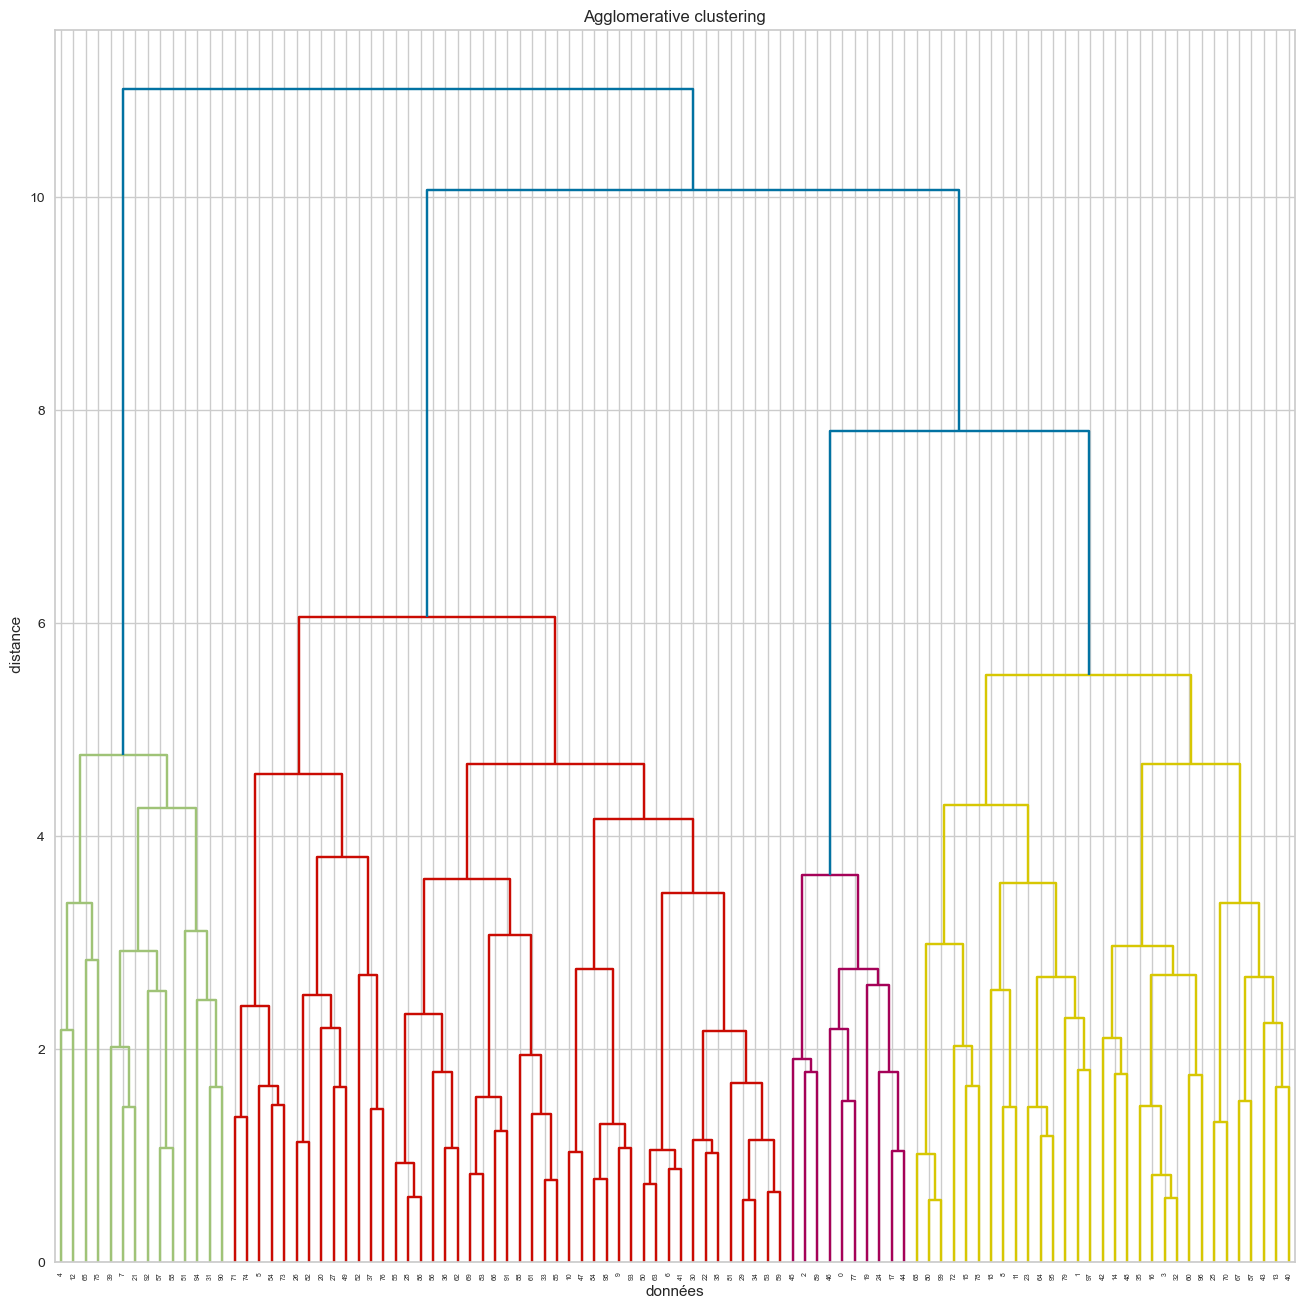

In [64]:
# Je vais utiliser 100 observations pour voir comment se fait
# le clustering agglomératif
plt.figure(1, figsize=(16, 16))
start_dendo = time.time()
dendrogram = sch.dendrogram(sch.linkage(
                            X_agglo.sample(100),
                            method="ward"))
plt.title('Agglomerative clustering')
plt.xlabel('données')
plt.ylabel(' distance')
plt.show()


#### <span style='background:Thistle'>2.4.2.1 Calcul des métriques</span>

Comme le coefficient de silhouette et l'indice Calinski-Harabasz, l'indice Davies-Bouldin (DB) capture à la fois la séparation et la compacité des clusters. Cela est dû au fait que l'instruction 'max' de la mesure sélectionne à plusieurs reprises les valeurs où le point moyen est le plus éloigné de son centre, et où les centres sont les plus proches les uns des autres. Mais contrairement au coefficient de silhouette et à l'indice Calinski-Harabasz, à mesure que l'indice DB diminue, le regroupement s'améliore.

In [65]:
silhouette = []
davies_bouldin = []
calin_harab = []
result_nclusters = []
n_clusters = range(2, 10)
for n in n_clusters:
    agglo_clust = AgglomerativeClustering(n_clusters=n,
                                          linkage='ward',
                                          affinity='euclidean')
    preds = agglo_clust.fit_predict(X_agglo)
    silh = silhouette_score(X_agglo, preds)
    db = davies_bouldin_score(X_agglo, preds)
    cal_har = calinski_harabasz_score(X_agglo, preds)
    silhouette.append(silh)
    davies_bouldin.append(db)
    calin_harab.append(cal_har)
    result_nclusters.append(n)
    metrique_agglo = pd.DataFrame({
        'n_clusters': result_nclusters,
        'coef_silh': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calin_harab})

In [66]:
metrique_agglo

n_clusters  coef_silh  davies_bouldin  calinski_harabasz
0           2   0.208068        1.766434        4417.544227
1           3   0.113245        2.149770        4047.284454
2           4   0.102126        2.219944        3531.949834
3           5   0.100065        2.191752        3198.953492
4           6   0.078324        2.121315        2861.875329
5           7   0.078308        2.093554        2645.394516
6           8   0.074269        2.065837        2481.429038
7           9   0.081165        1.937038        2334.957952

In [67]:
agglo_clust = AgglomerativeClustering(n_clusters=5,
                                      linkage='ward',
                                      affinity='euclidean')
preds = agglo_clust.fit_predict(X_agglo)
agglo_cluster_label = agglo_clust.labels_
X_agglo_cluster = X_agglo.assign(Cluster=agglo_clust.labels_)

In [68]:
metrique_agglo_opt = metrique_agglo.iloc[2,1:]
metrique_agglo_opt

coef_silh               0.102126
davies_bouldin          2.219944
calinski_harabasz    3531.949834
Name: 2, dtype: float64

#### <span style='background:Thistle'>2.4.2.2 Analyse des clusters</span>

In [69]:
X_agglo_cluster['Cluster'].value_counts(normalize=True) * 100

0    34.746667
2    22.530000
3    14.586667
4    14.133333
1    14.003333
Name: Cluster, dtype: float64

In [70]:
taille_cluster(agglo_cluster_label)

In [71]:
data_agglo['Cluster'] = X_agglo_cluster['Cluster']

In [72]:
data_agglo.head()

customer_state order_purchase_timestamp  \
customer_unique_id                                                         
95b0bd5e07b0079932a7496664f2e854        sud_est      2018-03-22 17:24:17   
22b99efa9116be57aac5b00ee65f097b        sud_est      2017-09-12 00:22:40   
2ca9046b6d18c4fc6eba3cf528b1ad73            sud      2017-05-19 19:00:36   
e4b3e45ac955d17778da4106ac255288        sud_est      2018-03-12 20:52:05   
4162c8f38b17df48915250f4fcd3a080   centre_ouest      2017-12-12 22:05:02   

                                 payment_type product_category_name  \
customer_unique_id                                                    
95b0bd5e07b0079932a7496664f2e854  credit_card                  home   
22b99efa9116be57aac5b00ee65f097b  credit_card                  home   
2ca9046b6d18c4fc6eba3cf528b1ad73  credit_card           consumption   
e4b3e45ac955d17778da4106ac255288  credit_card           consumption   
4162c8f38b17df48915250f4fcd3a080  credit_card           consumption   

                                  nbre_commande  nbre_produit  montant_achat  \
customer_unique_id                                                             
95b0bd5e07b0079932a7496664f2e854              1             1          56.99   
22b99efa9116be57aac5b00ee65f097b              1             1          89.65   
2ca9046b6d18c4fc6eba3cf528b1ad73              1             1         229.99   
e4b3e45ac955d17778da4106ac255288              1             1         139.90   
4162c8f38b17df48915250f4fcd3a080              1             1         243.89   

                                  score_moyen  delai_livraison  recence  \
customer_unique_id                                                        
95b0bd5e07b0079932a7496664f2e854          4.0               19      159   
22b99efa9116be57aac5b00ee65f097b          5.0                7      351   
2ca9046b6d18c4fc6eba3cf528b1ad73          5.0               10      466   
e4b3e45ac955d17778da4106ac255288          5.0               15      169   
4162c8f38b17df48915250f4fcd3a080          5.0               10      259   

                                  frequence  montant  Cluster  
customer_unique_id                                             
95b0bd5e07b0079932a7496664f2e854          1    64.11        0  
22b99efa9116be57aac5b00ee65f097b          1   103.30        0  
2ca9046b6d18c4fc6eba3cf528b1ad73          1   248.85        2  
e4b3e45ac955d17778da4106ac255288          1   154.96        0  
4162c8f38b17df48915250f4fcd3a080          1   260.36        2

In [73]:
X_agglo_cluster.head()

nbre_commande  score_moyen  delai_livraison  \
customer_unique_id                                                              
95b0bd5e07b0079932a7496664f2e854       0.693147     1.609438         2.995732   
22b99efa9116be57aac5b00ee65f097b       0.693147     1.791759         2.079442   
2ca9046b6d18c4fc6eba3cf528b1ad73       0.693147     1.791759         2.397895   
e4b3e45ac955d17778da4106ac255288       0.693147     1.791759         2.772589   
4162c8f38b17df48915250f4fcd3a080       0.693147     1.791759         2.397895   

                                   recence  frequence   montant  \
customer_unique_id                                                
95b0bd5e07b0079932a7496664f2e854  5.075174   0.693147  4.176078   
22b99efa9116be57aac5b00ee65f097b  5.863631   0.693147  4.647271   
2ca9046b6d18c4fc6eba3cf528b1ad73  6.146329   0.693147  5.520861   
e4b3e45ac955d17778da4106ac255288  5.135798   0.693147  5.049600   
4162c8f38b17df48915250f4fcd3a080  5.560682   0.693147  5.565899   

                                  customer_state_centre_ouest  \
customer_unique_id                                              
95b0bd5e07b0079932a7496664f2e854                            0   
22b99efa9116be57aac5b00ee65f097b                            0   
2ca9046b6d18c4fc6eba3cf528b1ad73                            0   
e4b3e45ac955d17778da4106ac255288                            0   
4162c8f38b17df48915250f4fcd3a080                            1   

                                  customer_state_nord  \
customer_unique_id                                      
95b0bd5e07b0079932a7496664f2e854                    0   
22b99efa9116be57aac5b00ee65f097b                    0   
2ca9046b6d18c4fc6eba3cf528b1ad73                    0   
e4b3e45ac955d17778da4106ac255288                    0   
4162c8f38b17df48915250f4fcd3a080                    0   

                                  customer_state_nord_est  customer_state_sud  \
customer_unique_id                                                              
95b0bd5e07b0079932a7496664f2e854                        0                   0   
22b99efa9116be57aac5b00ee65f097b                        0                   0   
2ca9046b6d18c4fc6eba3cf528b1ad73                        0                   1   
e4b3e45ac955d17778da4106ac255288                        0                   0   
4162c8f38b17df48915250f4fcd3a080                        0                   0   

                                  ...  payment_type_boleto  \
customer_unique_id                ...                        
95b0bd5e07b0079932a7496664f2e854  ...                    0   
22b99efa9116be57aac5b00ee65f097b  ...                    0   
2ca9046b6d18c4fc6eba3cf528b1ad73  ...                    0   
e4b3e45ac955d17778da4106ac255288  ...                    0   
4162c8f38b17df48915250f4fcd3a080  ...                    0   

                                  payment_type_credit_card  \
customer_unique_id                                           
95b0bd5e07b0079932a7496664f2e854                         1   
22b99efa9116be57aac5b00ee65f097b                         1   
2ca9046b6d18c4fc6eba3cf528b1ad73                         1   
e4b3e45ac955d17778da4106ac255288                         1   
4162c8f38b17df48915250f4fcd3a080                         1   

                                  payment_type_debit_card  \
customer_unique_id                                          
95b0bd5e07b0079932a7496664f2e854                        0   
22b99efa9116be57aac5b00ee65f097b                        0   
2ca9046b6d18c4fc6eba3cf528b1ad73                        0   
e4b3e45ac955d17778da4106ac255288                        0   
4162c8f38b17df48915250f4fcd3a080                        0   

                                  payment_type_voucher  \
customer_unique_id                                       
95b0bd5e07b0079932a7496664f2e854                     0   
22b99efa9116be57aac5b00ee65f097b                     0   
2ca9046b6d18c4fc6eba3cf528b1ad73          

In [74]:
cluster_size

{0: 10424, 2: 6759, 1: 4201, 3: 4376, 4: 4240}

In [75]:
cluster_analysis(0, data_agglo)

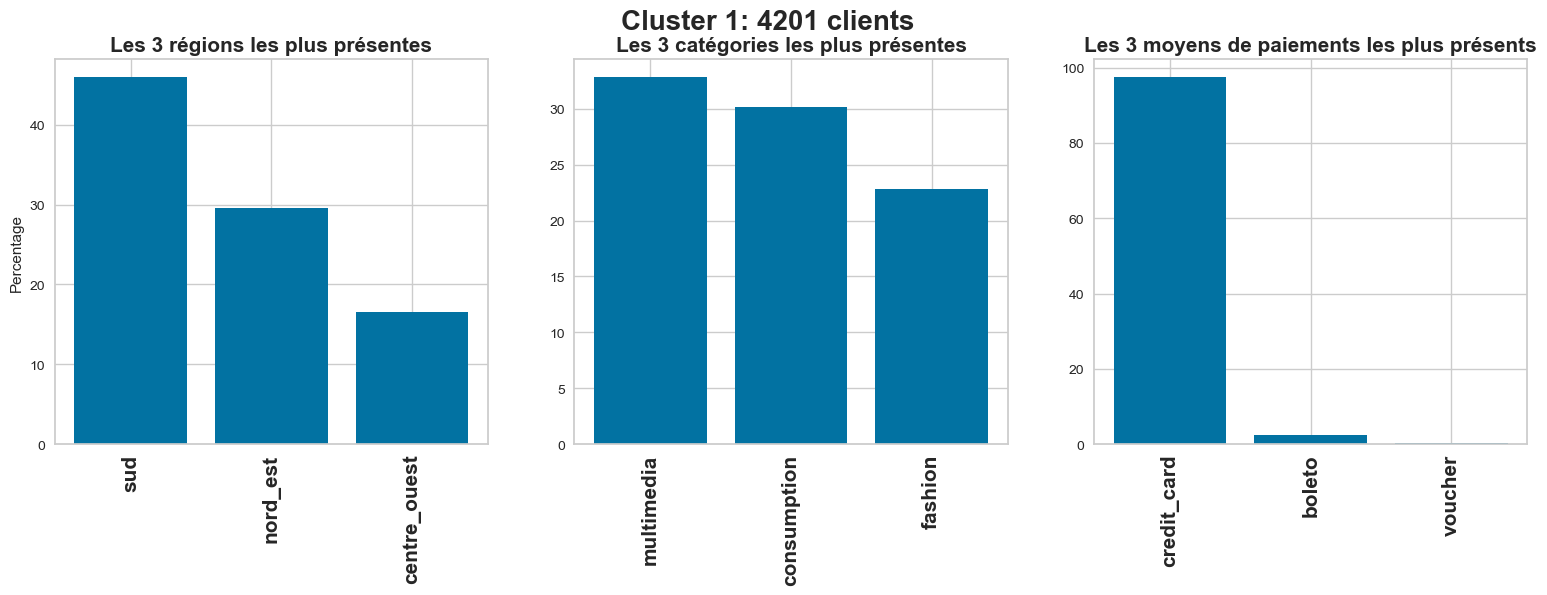

In [76]:
cluster_analysis(1, data_agglo)

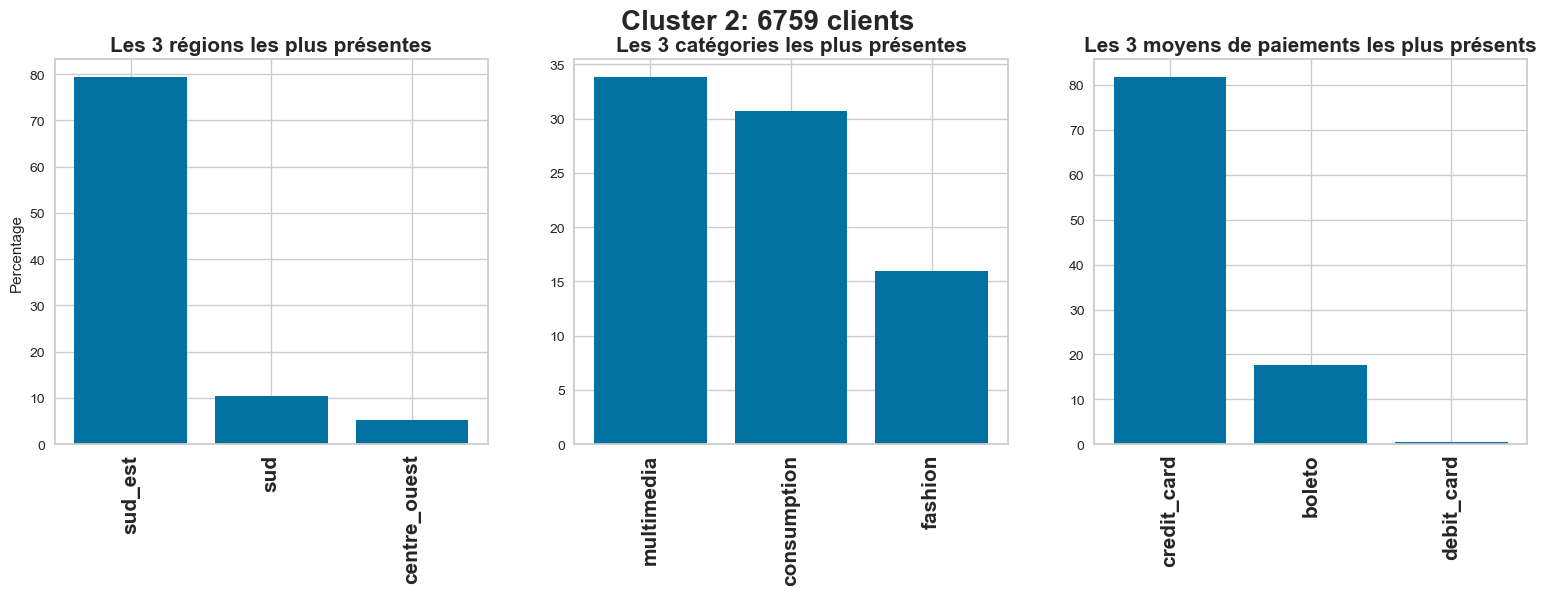

In [77]:
cluster_analysis(2, data_agglo)

In [78]:
cluster_analysis(3, data_agglo)

In [79]:
groupe_agglo = data_agglo.groupby(['Cluster'])
groupe_agglo.agg({
                  'recence': ['min', 'mean', 'median', 'max'],
                  'frequence':  ['min', 'mean', 'median', 'max'],
                  'montant':  ['min', 'mean', 'median', 'max'],
                  'score_moyen':  ['min', 'mean', 'median', 'max'],
                  'delai_livraison':  ['min', 'mean', 'median', 'max']
                 }).round(1)

recence                    frequence                 montant         \
            min   mean median  max       min mean median max     min   mean   
Cluster                                                                       
0             8  263.7  249.0  694         1  1.1    1.0   5     0.0  110.2   
1            11  281.7  268.0  694         1  1.1    1.0   9     5.4  129.5   
2            13  251.8  225.0  694         1  2.0    2.0  13    29.6  443.2   
3            21  279.8  266.0  694         1  1.2    1.0   6     3.8  111.0   
4             0   39.3   29.0  275         1  1.3    1.0  14     6.6  185.7   

                       score_moyen                  delai_livraison        \
        median     max         min mean median  max             min  mean   
Cluster                                                                     
0         84.6  1562.7         1.0  4.2    5.0  5.0               1  11.0   
1        104.1  1483.1         1.0  4.1    5.0  5.0               1  17.3   
2        336.3  5076.0         1.0  3.9    5.0  5.0               0  11.1   
3         80.8  1070.3         1.0  4.2    5.0  5.0               1  12.7   
4        117.8  2459.5         1.0  4.3    5.0  5.0               1   8.1   

                     
        median  max  
Cluster              
0          9.0  136  
1         15.0  195  
2          9.0  124  
3         11.0  108  
4          7.0   88

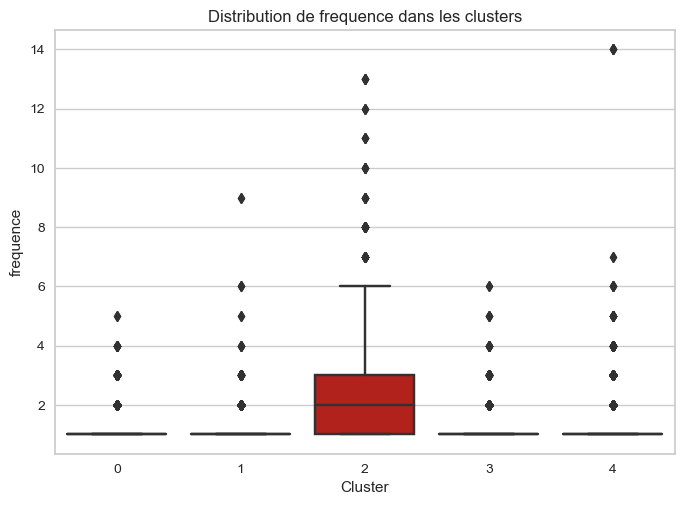

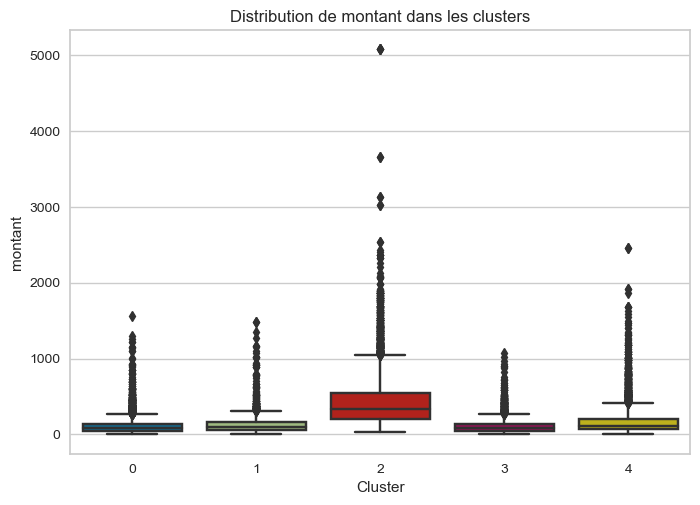

In [80]:
colonnes_agglo = ["recence", "frequence", "montant",
                  "score_moyen", "delai_livraison"]
distribution_cluster(data_agglo, colonnes_agglo)

### <span style='background:Thistle'>2.4.3 DBSCAN</span>


DBSCAN est un algorithme de clustering qui s’appuie sur la densité estimée des clusters pour effectuer le partitionnement.

L'algorithme DBSCAN utilise 2 paramètres :

La distance epsilon

Le nombre minimum de points MinPts devant se trouver dans un rayon epsilon pour que ces points soient considérés comme un cluster.
Les paramètres d'entrées sont donc une estimation de la densité de points des clusters.
L'idée de base de l'algorithme est ensuite, pour un point donné, de récupérer son epsilon-voisinage et de vérifier qu'il contient bien MinPts points ou plus. Ce point est alors considéré comme faisant partie d'un cluster.
On parcourt ensuite l'epsilon-voisinage de proche en proche afin de trouver l'ensemble des points du cluster.

Contrairement à KMeans, le nombre de Cluster n'est pas défini  à l'avance.

data_dbscan = data1[['score_moyen', 'delai_livraison',
                     'recence', 'frequence', 'montant']].copy()
data_dbscan = data_dbscan.sample(30000)
dbscan_index = data_dbscan.index.to_list()
dbs = data_olist.copy()
data_dbscann = dbs.loc[dbscan_index, :]

In [81]:
data_dbscan = data1.sample(n=30000, random_state=2).copy()
dbscan_index = data_dbscan.index.to_list()
dbs = data_olist.copy()
data_dbscann = dbs.loc[dbscan_index, :]
data_dbscann = data_dbscann.set_index('customer_unique_id')
data_dbscan = data_dbscan.set_index('customer_unique_id')

#### <span style='background:Thistle'>2.4.3.1 Calcul des métriques</span>

dbscan_a_normaliser = scaler.fit_transform(data_dbscan)
data_dbscan = pd.DataFrame(dbscan_a_normaliser,
                                 columns=data_dbscan.columns,
                                 index=data_dbscan.index.to_list())

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_dbscan)
distances, indices = nbrs.kneighbors(data_dbscan)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [209]:
#'''
# recherche de l'hyperparamtre epsilon
silhouette = []
davies_bouldin = []
calin_harab = []
result_ebs = []
eps = [1.4, 1.412, 1.415, 1.418, 1.42]
for ebsilon in eps:
    dbscan = DBSCAN(eps=ebsilon,
                    min_samples=10)
    preds = dbscan.fit_predict(data_dbscan)
    silh = silhouette_score(data_dbscan, preds)
    db = davies_bouldin_score(data_dbscan, preds)
    cal_har = calinski_harabasz_score(data_dbscan, preds)
    silhouette.append(silh)
    davies_bouldin.append(db)
    calin_harab.append(cal_har)
    result_ebs.append(ebsilon)
    metrique_dbscan = pd.DataFrame({
                    'ebsilon': result_ebs,
                    'coef_silh': silhouette,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calin_harab})
#'''

In [210]:
metrique_dbscan

ebsilon  coef_silh  davies_bouldin  calinski_harabasz
0    1.400   0.140043        2.182425         353.319425
1    1.412   0.140774        2.178485         353.475090
2    1.415  -0.081858        2.343800          33.975507
3    1.418   0.054099        2.894431          55.766985
4    1.420   0.146483        3.112439          76.141293

In [192]:
# Instanciation de dbscan avec les meilleurs paramètres
dbscan = DBSCAN(eps=1.4,
                min_samples=200
                )
# Entraînement du modèle
dbscan.fit(data_dbscan)
dbscan_labels = dbscan.labels_
data_dbscan1 = data_dbscan.assign(Cluster=dbscan_labels)

In [194]:
np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18], dtype=int64)

#### <span style='background:Thistle'>2.4.3.2 Analyse des clusters</span>

In [195]:
data_dbscan1['Cluster'].value_counts(normalize=True) * 100

-1     18.010000
 2     17.256667
 6     13.113333
 5      9.583333
 0      7.656667
 13     5.423333
 9      3.896667
 4      3.733333
 1      3.250000
 11     2.556667
 7      2.333333
 15     2.093333
 10     2.073333
 12     2.010000
 3      1.416667
 8      1.410000
 14     1.246667
 16     1.076667
 17     1.046667
 18     0.813333
Name: Cluster, dtype: float64

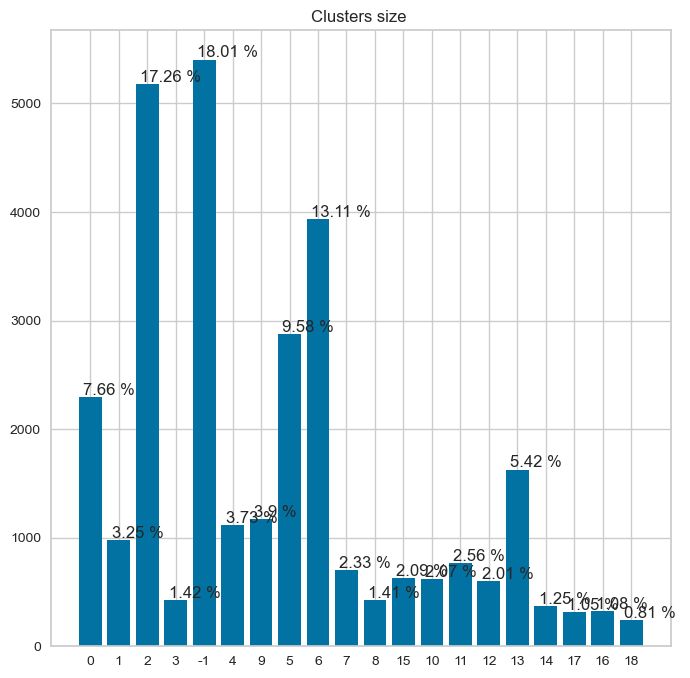

In [196]:
taille_cluster(dbscan_labels)

In [197]:
data_dbscan_analyse = data_dbscann.copy()
data_dbscan_analyse['Cluster'] = data_dbscan1['Cluster']

In [198]:
cluster_size

{0: 2297,
 1: 975,
 2: 5177,
 3: 425,
 -1: 5403,
 4: 1120,
 9: 1169,
 5: 2875,
 6: 3934,
 7: 700,
 8: 423,
 15: 628,
 10: 622,
 11: 767,
 12: 603,
 13: 1627,
 14: 374,
 17: 314,
 16: 323,
 18: 244}

In [204]:
cluster_analysis(2, data_dbscan_analyse)

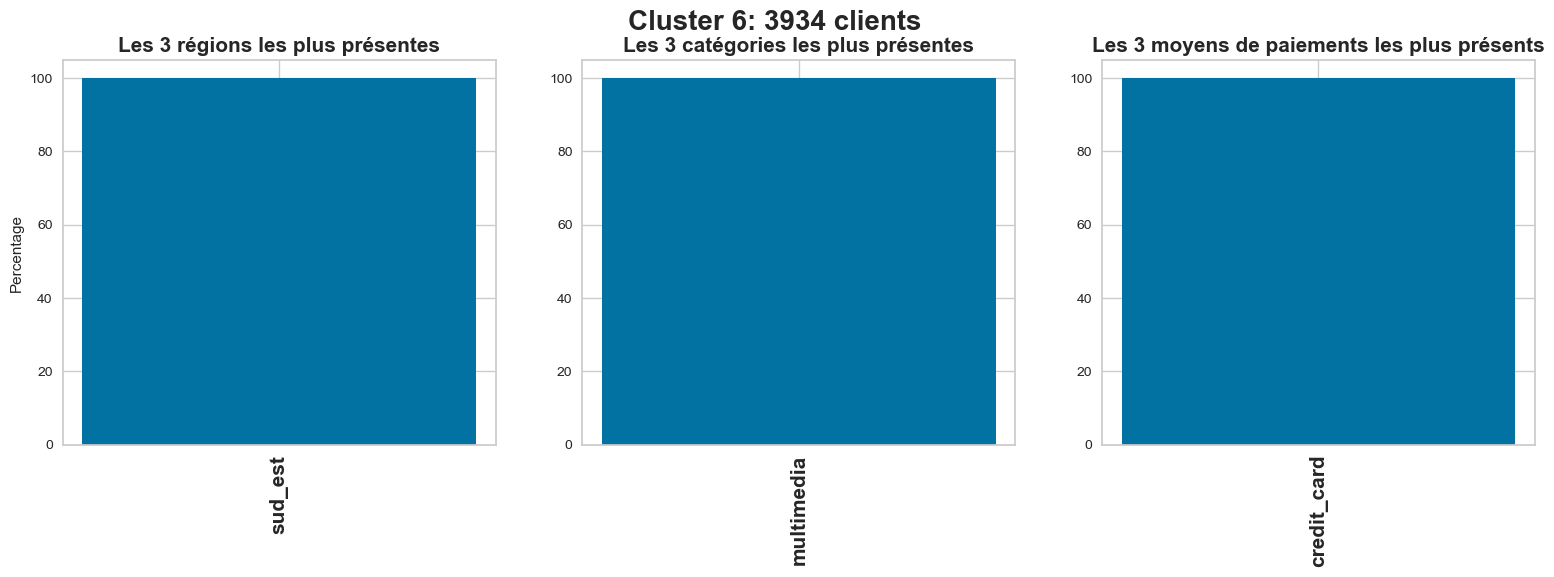

In [205]:
cluster_analysis(6, data_dbscan_analyse)

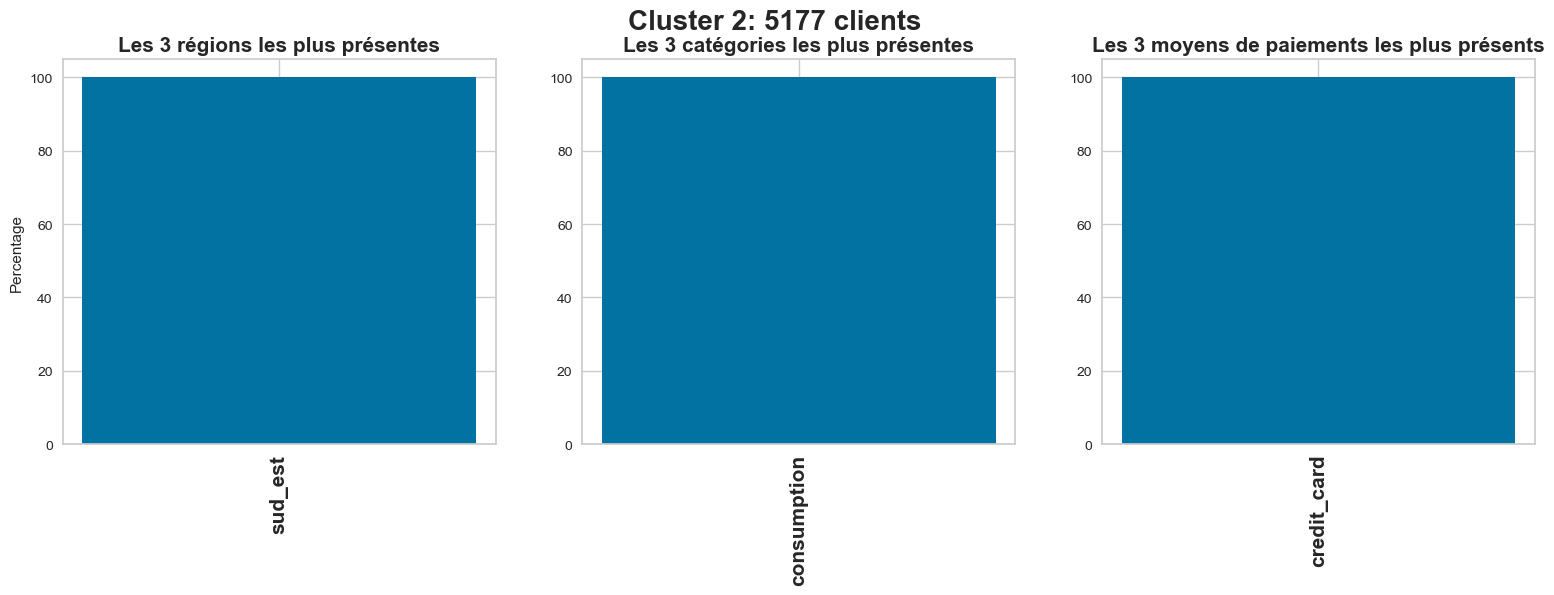

In [201]:
cluster_analysis(2, data_dbscan_analyse)

In [202]:
groupe_dbscan = data_dbscan_analyse.groupby(['Cluster'])
groupe_dbscan.agg({
                  'recence': ['min', 'mean', 'median', 'max'],
                  'frequence':  ['min', 'mean', 'median', 'max'],
                  'montant':  ['min', 'mean', 'median', 'max'],
                  'score_moyen':  ['min', 'mean', 'median', 'max'],
                  'delai_livraison':  ['min', 'mean', 'median', 'max']
                  }).round(1)

recence                    frequence                 montant         \
            min   mean median  max       min mean median max     min   mean   
Cluster                                                                       
-1            0  218.9  200.0  694         1  1.5    1.0  14     0.0  257.8   
 0            4  235.2  218.0  693         1  1.5    1.0   9     4.8  225.1   
 1           10  250.0  226.0  693         1  1.3    1.0   5    11.2  197.4   
 2            1  228.3  210.0  693         1  1.3    1.0   8     2.8  174.8   
 3           21  251.4  253.0  694         1  1.2    1.0   4    11.8  165.6   
 4           11  242.0  223.0  693         1  1.3    1.0   5    14.4  175.6   
 5            5  254.8  234.0  694         1  1.5    1.0   9     3.4  207.5   
 6            2  219.5  199.0  693         1  1.3    1.0   9     1.8  176.2   
 7           21  266.0  252.0  693         1  1.4    1.0   6    13.4  163.8   
 8           29  266.8  259.0  574         1  1.4    1.0   6    22.7  163.7   
 9            8  237.5  223.0  694         1  1.3    1.0   5    13.4  162.1   
 10          19  265.7  258.5  691         1  1.4    1.0   5    13.1  213.5   
 11          15  231.6  207.0  589         1  1.2    1.0   4     5.9  163.7   
 12          19  241.7  222.0  691         1  1.2    1.0   4     8.8  161.7   
 13           6  215.2  186.0  694         1  1.4    1.0   7     5.2  219.2   
 14          30  257.5  236.5  575         1  1.3    1.0   5    15.6  159.0   
 15          19  243.9  225.5  691         1  1.2    1.0   4    14.8  185.8   
 16          35  257.2  226.0  585         1  1.3    1.0   3    17.0  144.4   
 17          40  302.4  295.0  694         1  1.3    1.0   6    18.6  189.0   
 18          46  243.2  229.5  571         1  1.1    1.0   3    23.2  119.8   

                       score_moyen                  delai_livraison        \
        median     max         min mean median  max             min  mean   
Cluster                                                                     
-1       129.0  5076.0         1.0  4.0    5.0  5.0               1  14.8   
 0       129.6  2130.0         1.0  4.0    5.0  5.0               1  10.7   
 1       130.2  1206.5         1.0  4.2    5.0  5.0               1  12.8   
 2       115.4  1917.0         1.0  4.2    5.0  5.0               0   9.1   
 3       116.9   793.8         1.0  4.2    5.0  5.0               1  13.6   
 4        99.9  1566.6         1.0  4.0    5.0  5.0               1  11.4   
 5       120.4  2409.3         1.0  4.2    5.0  5.0               1   9.8   
 6       110.4  2372.8         1.0  4.1    5.0  5.0               0  10.3   
 7        98.7  1174.4         1.0  4.2    5.0  5.0               1  10.9   
 8       111.0   724.7         1.0  4.0    5.0  5.0               1  12.2   
 9        98.2  1336.6         1.0  4.2    5.0  5.0               1  10.1   
 10      134.4  1306.4         1.0  4.2    5.0  5.0               1  12.9   
 11      104.7  1473.1         1.0  4.1    5.0  5.0               1  13.5   
 12      120.1  1083.9         1.0  3.9    5.0  5.0               3  19.0   
 13      137.2  1905.6         1.0  4.1    5.0  5.0               1   9.7   
 14      123.2   734.0         1.0  4.0    5.0  5.0               2  14.3   
 15      140.2  1368.4         1.0  4.1    5.0  5.0               2  18.1   
 16      111.4   665.2         1.0  4.3    5.0  5.0               2  11.4   
 17      136.4   936.7         1.0  3.9    5.0  5.0               6  20.0   
 18       99.9   420.8         1.0  4.2    5.0  5.0               3  14.8   

                     
        median  max  
Cluster              
-1        13.0  195  
 0         9.0  136  
 1        11.0   74  
 2         7.0  145  
 3        12.0   55  
 4        10.0   68  
 5         8.0   69  
 6         8.0   87  
 7         9.0   75  
 8        10.0   66  
 9         8.0   73  
 10       11.0   50  
 11       11.0   77  
 12       16.0   86  
 13        8.0   61  
 14       12.0   54  


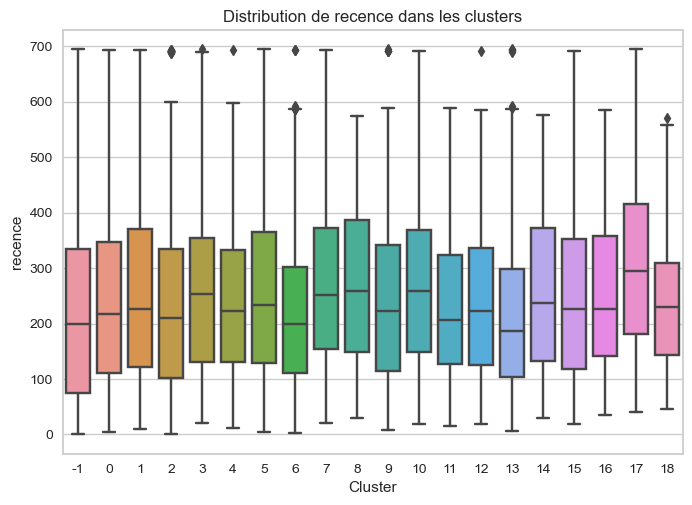

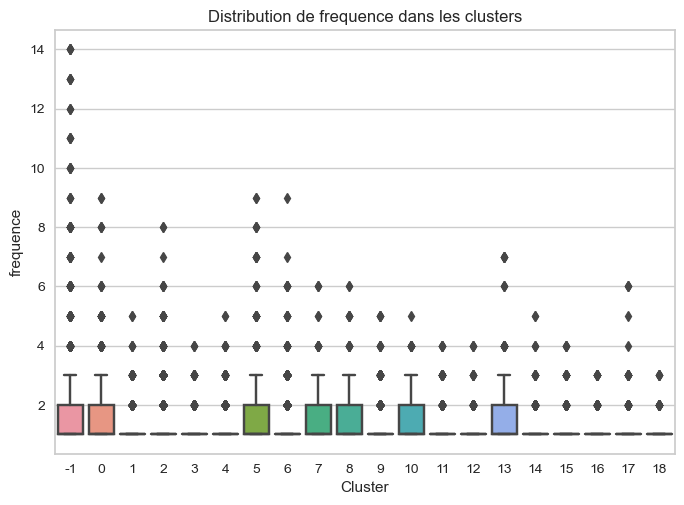

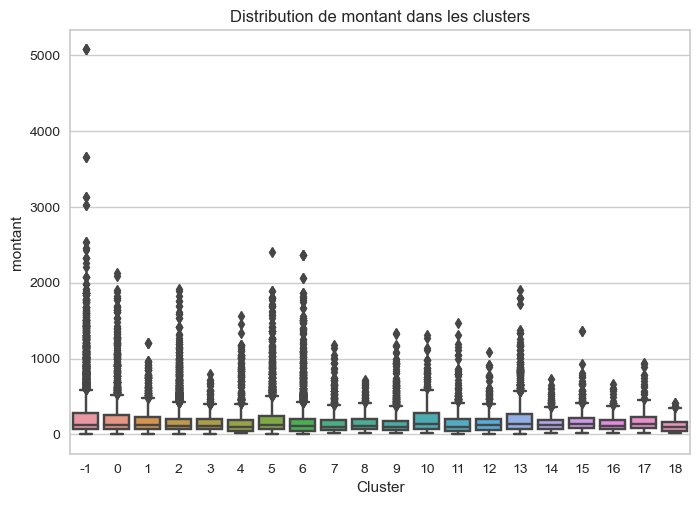

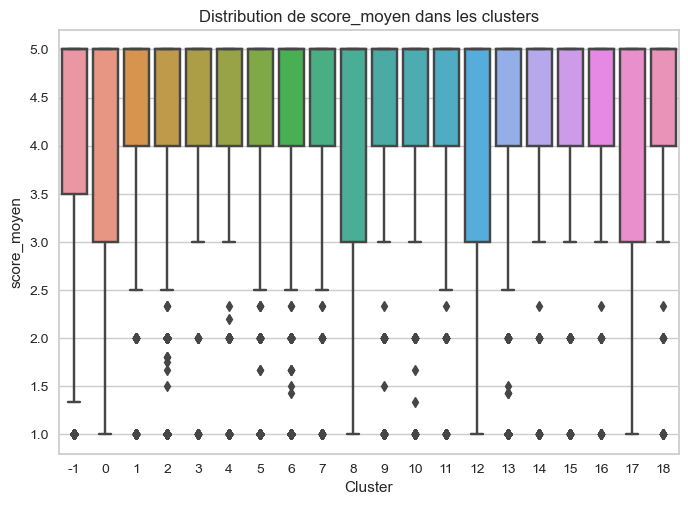

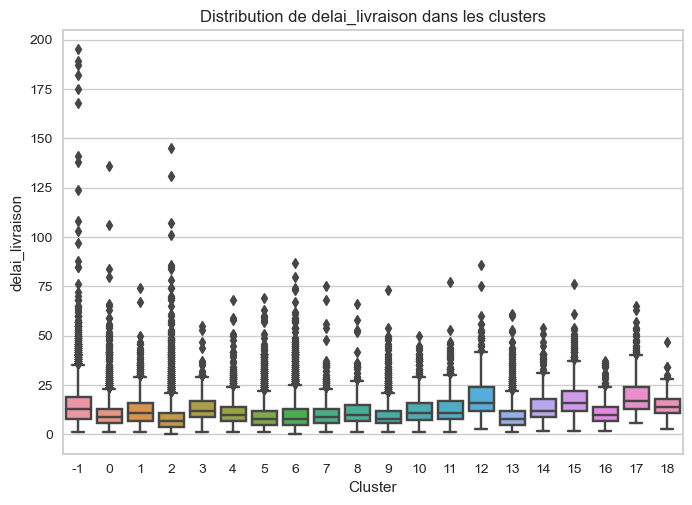

In [203]:
colonnes_dbscan = ["recence", "frequence", "montant",
                   "score_moyen", "delai_livraison"]
distribution_cluster(data_dbscan_analyse, colonnes_dbscan)

DBSCAN repose sur le concept de densité : un cluster est une zone de l’espace où la densité d’observations est importante. En sortie, l’algorithme génère autant de clusters que de zones de l’espace de forte densité. Les points isolés sont considérés comme des outliers (valeurs aberrantes). Il semble que cet alogorithme n'est pas adapté à notre jeu de données

## <span style='background:Thistle'>3 Conclusion</span>


J'ai partitionné le dataset clients en utilisant la segmentation RFM et differents algorithmes d'apprentissage non supervisé dont K-Means, la classification hiérarchique ascendante selon Ward, et DBSCAN. 
Les resultas tournent autour de 5 clusters.
Les meilleurs scores (silouette, distortion, Calinski-Harabasz) sont obtenus par le modele K-Means dont on garde les resultats.

# Interprétation métier des clusters



40 % - (Les Clients Nouveaux) avec la plus petite récence, la plus petite fréquence, la plus petite valeur monétaire, la plus grande note et le plus petit delai de livaraison.

Stratégie CRM : Communication standard pour l'envoi d'offres ; Proposez des produits pertinents et de bonnes affaires.


14 % - (Les Clients Perdus) avec plus grande récence, plus petite fréquence, petite valeur monétaire, la note la plus élevée et delai de livraison faible.

Stratégie CRM : Offrez des remises ; Recommandation de produits populaires.


1 % - (Les Clients Fidèles) avec récence intermédiare, la plus grande fréquence, la plus grande valeur monétaire, bonne note et delai de livraison intermédiare.

Stratégie CRM : Offrez des récompenses ; Offrez des remises.


14% - (Les Clients à Risque) avec récence intermédiare, fréquence intermédiare, valeur monétaire intermédiare, note intermédiare et delai de livraison intermédiare.

Stratégie CRM : Communication personnalisée ; Proposer peu de produits, mais présenter des produits susceptibles de les intéresser ; Des offres spéciales, des produits et des réductions pour ces clients afin qu'ils se sentent valorisés ; Demandez constamment des avis et des commentaires ; Évitez d'envoyer des quantités massives d'offres ; Donnez des récompenses.


31% - (Les clients Infidèles) avec une récence intermédiare,  petite frequence , valeur monétaire intermédiare, plus petit score et le plus grand delai de livraison 

Stratégie CRM : Campagnes promotionnelles pour un temps limité ; Recommandations de produits en fonction de leur comportement ; Montrez l'importance d'acheter avec l'entreprise.

In [127]:
data2 = data1.copy()
data2 = data2.set_index('customer_unique_id')

df1 = data2.sample(10000).copy()
df2 = data2.sample(10000).copy()
df3 = data2.sample(10000).copy()
df4 = data2.sample(10000).copy()
df5 = data2.sample(10000).copy()
set_data = [df1, df2, df3, df4, df5]

In [128]:
agglo_clust = AgglomerativeClustering(n_clusters=5,
                                          linkage='ward',
                                          affinity='euclidean')

silhouette = []
davies_bouldin = []
calin_harab = []
n_df = []
i = 0
for df in set_data:
    i+=1
    preds = agglo_clust.fit_predict(df)
    silh = silhouette_score(df, preds)
    db = davies_bouldin_score(df, preds)
    cal_har = calinski_harabasz_score(df, preds)
    silhouette.append(silh)
    davies_bouldin.append(db)
    calin_harab.append(cal_har)
    n_df.append(i)
    
metrique_agglo = pd.DataFrame({
        'num_df': n_df,
        'coef_silh': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calin_harab})

In [129]:
metrique_agglo

num_df  coef_silh  davies_bouldin  calinski_harabasz
0       1   0.102468        2.155266        1073.365633
1       2   0.105419        2.226412        1051.500412
2       3   0.110784        2.116946        1086.065534
3       4   0.100906        2.089536        1083.076089
4       5   0.111768        2.152450        1082.919334

In [130]:
dbscan = DBSCAN(eps=1,
                min_samples=10,
                )

silhouette = []
davies_bouldin = []
calin_harab = []
n_df = []
i = 0
for df in set_data:
    i+=1
    preds = dbscan.fit_predict(df)
    silh = silhouette_score(df, preds)
    db = davies_bouldin_score(df, preds)
    cal_har = calinski_harabasz_score(df, preds)
    silhouette.append(silh)
    davies_bouldin.append(db)
    calin_harab.append(cal_har)
    n_df.append(i)
    
metrique_dbscan = pd.DataFrame({
        'num_df': n_df,
        'coef_silh': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calin_harab})

In [131]:
metrique_dbscan

num_df  coef_silh  davies_bouldin  calinski_harabasz
0       1   0.068200        2.120548         150.880852
1       2   0.114011        2.112274         155.347914
2       3   0.085968        2.067724         154.721089
3       4   0.077288        2.088778         150.025734
4       5   0.072303        2.060732         148.185762

In [132]:
kmeans_clust = KMeans(n_clusters=5, init='k-means++', max_iter=100)


silhouette = []
davies_bouldin = []
calin_harab = []
n_df = []
i = 0
for df in set_data:
    i+=1
    preds = kmeans_clust.fit_predict(df)
    silh = silhouette_score(df, preds)
    db = davies_bouldin_score(df, preds)
    cal_har = calinski_harabasz_score(df, preds)
    silhouette.append(silh)
    davies_bouldin.append(db)
    calin_harab.append(cal_har)
    n_df.append(i)
    
metrique_kmeans = pd.DataFrame({
        'num_df': n_df,
        'coef_silh': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calin_harab})

In [133]:
metrique_kmeans

num_df  coef_silh  davies_bouldin  calinski_harabasz
0       1   0.130732        1.994018        1432.500567
1       2   0.136055        1.981886        1442.606753
2       3   0.129176        2.003570        1433.769553
3       4   0.131691        2.005472        1455.656869
4       5   0.136775        1.965019        1448.360887

In [134]:
metrique_kmeans.set_index('num_df').mean()

coef_silh               0.132886
davies_bouldin          1.989993
calinski_harabasz    1442.578926
dtype: float64

In [135]:
metrique_agglo.set_index('num_df').mean()

coef_silh               0.106269
davies_bouldin          2.148122
calinski_harabasz    1075.385400
dtype: float64

In [136]:
metrique_dbscan.set_index('num_df').mean()

coef_silh              0.083554
davies_bouldin         2.090011
calinski_harabasz    151.832270
dtype: float64